In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ImageManipulation as IM
import os
import findPeaksLib
import GaussFits
import pickle
from GaussAnalysisPipeline import *
import precisionFuncs as pF

# helper functions

In [2]:
# -*- coding: utf-8 -*-
"""
Created on Mon Dec  9 10:35:29 2019

@author: buddeja
"""
import shutil
import pandas as pd

def mergePTUfiles(path, savepath):
    files = os.listdir(path)
    file_folder = []


    if os.path.exists(savepath) == True:
         print('savepath_exists')
    else:
        os.makedirs(savepath)  

    for i in files:
        if i.startswith('Overview'):
            file_folder.append(i)

    for ii in file_folder:
        print(ii)

        files_ptu = []
        files_xcoord = []
        files_ycoord = []
        x_relative = []
        y_relative = []
        folderpath = '{}{}{}'.format(path, ii, '/')
        files_folderpath = os.listdir(folderpath)
        for i in files_folderpath:
            if i.endswith('.ptu'):
                files_ptu.append(i)
            elif i.endswith('x_transfer.dat.dat'):
                x_coord = i
            elif i.endswith('y_transfer.dat.dat'):
                y_coord = i
        if len(files_ptu) >0 :

            filex = pd.read_csv('{}{}'.format(folderpath,x_coord),sep='\t')
            filey = pd.read_csv('{}{}'.format(folderpath,y_coord),sep='\t')
            filex = [i[0] for i in filex.values.tolist()]
            filey = [i[0] for i in filey.values.tolist()]
            x_relative.extend(filex) 
            y_relative.extend(filey) 
            for i in range(len(files_ptu)):
                name_new = '{}{}{}{}{}{}'.format(files_ptu[i][:-4],'_x_',x_relative[i],'_y_',y_relative[i],'.ptu')
                shutil.copy('{}{}'.format(folderpath, files_ptu[i]), '{}{}'.format(savepath, name_new))

In [ ]:
def getROI(im, ROIsize):
    assert ROIsize % 2 == 0
    ROIside = ROIsize / 2
    smooth_im = findPeaksLib.smooth_image(im)
    xlen, ylen = im.shape
    maxpos = smooth_im.argmax()
    xpos, ypos = [maxpos // xlen, maxpos % xlen]
    ROI = np.array([xpos - ROIside, ypos - ROIside, xpos + ROIside, ypos + ROIside]).astype(np.int)
    return ROI

def crop(image, ROI):
    """crop ROI from image
    ROI: roi parameters as taken from getROI
    returns cropped image"""
    xshape, yshape = image.shape
    if ROI[0] < 0 or ROI[1] < 0 or ROI[2] >= xshape or ROI[3] >= yshape:
        raise IndexError
    return image[ROI[0]: ROI[2], ROI[1]: ROI[3]]

In [171]:
def analyseCFdir(locLst, options, wdir, nfiles = -1, outname = 'SpotsObject.spots'):
    ntacs = 256
    for i, file in enumerate(files[:nfiles]):
        if file[-4:] != '.ptu':
            print('not a .ptu file, skipping')
            continue
        print('analysing image no. %i' %i)
        ffile = os.path.join(wdir, file)
        #froifile = os.path.join(roidir, roifile)

        #load image, gate
        CLR = IM.processLifetimeImage(ffile.encode(), uselines = np.array([1,2]), ntacs = ntacs)
        CLR.loadLifetime()
        CLR.rebin(5, 5)# rebin 100x100px image into 20x20px, 50nm /px
        CLR.loadIntensity()
        locLst.append({})
        locLst[-1]['filepath'] = ffile
        #loop over G and Y channels
        for color, bitmap in CLR.workIntensity.__dict__.items():
            if color in ['G', 'Y']:
                outdir = ffile[:-4] + '_' + color
                #fits 1, 2 or 3 gauss spots and determines which one is best
                #returns optimised parameter array
                bestfit, twoIstar, _ = fitNGauss (bitmap, options, verbose = False, outdir = outdir)
                #print(bestfit)
                #build array containing all the fit results
                locLst[-1][color] = Channel(bitmap)
                locLst[-1][color].fillSpotLst(bestfit)
    fpath = os.path.join(wdir, outname)
    with open(fpath, 'wb') as output:
        pickle.dump(locLst, output, 1)
    return locLst

In [ ]:
def analyseSTEDdir(locLst, options, wdir, files, Ggate = 0, Ygate = 0, 
                   DTwoIstar = 0.03, garbageBrightness = 20, junkIstar = 0.30,
                   outname = ''):
    ntacs = 256
    ROIsize = 20

    for i, file in enumerate(files):
        if file[-4:] != '.ptu':
            print('not a .ptu file, skipping')
            continue
        print('analysing image no. %i' %i)
        ffile = os.path.join(wdir, file)

        #load image, gate
        CLR = IM.processLifetimeImage(ffile.encode(), uselines = np.array([1,2]), ntacs = ntacs)
        CLR.loadLifetime()
        CLR.gate(Ggate, 150, channel = 'G')
        CLR.gate(Ygate, 150, channel = 'Y')
        CLR.loadIntensity()

        #get ROI based on Y signal
        ROI = getROI(CLR.workIntensity.Y, ROIsize)    
        
        #check that ROI is not touching borders:
        try:
            crop(CLR.workIntensity.G, ROI)
        except IndexError:
            print('ROI touches image borders, skipping')
            continue
            
        locLst.append({})
        locLst[-1]['filepath'] = ffile
        #loop over G and Y channels
        for color, bitmap in CLR.workIntensity.__dict__.items():
            if color in ['G', 'Y']:
                outdir = ffile[:-4] + '_' + color

                ROIsnip = crop(bitmap, ROI)
                #fits 1, 2 or 3 gauss spots and determines which one is best
                #returns optimised parameter array
                bestfit, twoIstar, _ = fitNGauss (ROIsnip, options, 
                                                  DTwoIstar = DTwoIstar, garbageBrightness = garbageBrightness,
                                                  junkIstar = junkIstar,
                                                  verbose = False, outdir = outdir)

                #build array containing all the fit results
                locLst[-1][color] = Channel(bitmap)
                locLst[-1][color].fillSpotLst(bestfit)
    
    fpath = os.path.join(wdir, outname)
    
    with open(fpath, 'wb') as output:
        pickle.dump(locLst, output, 1)
        
    return locLst

# Analysis functions

In [170]:
def plotSinglePair(locLst, pxSize = 10):
    coords = np.zeros([len(locLst),2])
    for i, loc in enumerate(locLst):
        coords[i] = loc['G'].spotLst[0].coord - loc['Y'].spotLst[0].coord
    coords *= pxSize
    coords = kickvector(coords, 50)
    coords = coords - np.mean(coords, axis = 0)
    plt.plot(coords[:,0], coords[:,1], '.')
    plt.plot([0,0], [-100,+100], 'r--')
    plt.plot([-100,+100], [0,0], 'r--')
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.xlim([-50, 50])
    plt.ylim([-50, 50])
    stdx, stdy = np.std(coords, axis = 0)
    print('standard deviation of spots is %.2f and %.2f' % (stdx, stdy))
    plt.show()
    return coords

def kickvector(dat, maxval):
    return dat[np.linalg.norm(dat, axis = 1) < maxval]

def plotOccurence(locLst):
    """plots a 2D histogram of how many spots have been fitted
    in the Green and red channel.
    Takes as argument a spotLst Lst"""
    occurence = np.zeros([4,4], np.int)
    for loc in locLst:
        Gspots = len(loc['G'].spotLst)
        Yspots = len(loc['Y'].spotLst)
        occurence[Gspots, Yspots] += 1
    plt.figure(figsize = [4,4])
    x, y = np.meshgrid(np.arange(4),np.arange(4))
    plt.scatter(x,y, s = occurence)
    ax = plt.gca()
    ax.set_xticks([0,1,2,3])
    ax.set_yticks([0,1,2,3])
    plt.ylabel ('# Green spots identified')
    plt.xlabel ('# red spots identified')
    plt.show
    return occurence
    

    
def selectSpotOccurence(locLst, Gspots, Yspots):
    """selects from locLst those localisations that have
    Gspots and Yspots. Gspots and Spots must be lists.
    returns: cleaned locLst"""
    i=0
    locLst_copy = locLst.copy()
    while i < len(locLst_copy):
        if (len(locLst_copy[i]['G'].spotLst) in Gspots and
                len(locLst_copy[i]['Y'].spotLst) in Yspots):
            i += 1
        else:
            locLst_copy.pop(i)
    return locLst_copy

from scipy.optimize import minimize
def logLikelihood1D(params, func, xdata, ydata):
    return np.sum(func(xdata, *params) - ydata * np.log(func(xdata, *params)))
def ncChidistr(r, mu, sig, A, offset):
    return A * r / sig**2 * np.exp(- (mu**2 + r**2) / (2 * sig**2)) * np.i0( r * mu / (sig**2)) + offset

# Unfinished code

In [ ]:
def matchSpotPairs(locLst):
    """returns the distance in x,y of all closest pairs
    function distances for all G-Y pairs.
    The closest pairs are returned. 
    A spot can be part of max 1 pair.
    Takes a locLst Lst as argument"""
    distLst = []
    for loc in locLst:
        Gcoords = []
        Ycoords = []
        for spot in loc['G'].spotLst:
            Gcoords.append(spot.coord)
        for spot in loc['Y'].spotLst:
            Ycoords.append(spot.coord)
        NG = len(Gcoords)
        NY = len(Ycoords)
        Ndist = min(NG, NY)
        dist = np.zeros(Ndist, 2)
        diff = np.zeros([NG, NY])
        for i in range(NG):
            for j in range(NY):
                diff[i,j] = np.linalg.norm(Gcoords[i] - Ycoords[j])
        for i in range(Ndist):
            NG, NY = diff.shape
            xpos, ypos = [diff.argmin() // NG , diff.argmin % NG]
            dist.append(Gcoords[xpos] - Ycoords[ypos])
            diff = np.delete(diff, xpos, 0)
            diff = np.delete(diff, ypos, 1)
        distLst.append(dist)
    return distLst

# CF C-L data

### Analyse data new

In [107]:
wdir = r'N:\Singlem\singlem20-1\January\24_CL_origami_NV\CF_run1\all'
files = os.listdir(wdir)
options = optionsCluster(fitbg = 0, setbg = 0.2, ellipt_circ = 0)
CLLst = []
analyseCFdir(CLLst, options, wdir)

NameError: name 'analyseCFdir' is not defined

### Load previously analysed data

In [5]:
wdir = r'N:\Singlem\singlem20-1\January\24_CL_origami_NV\CF_run1\all'
fpath = os.path.join(wdir, 'SpotsObject.spots')
with open(fpath, 'rb') as spotsfile:
    CLLst = pickle.load(spotsfile)

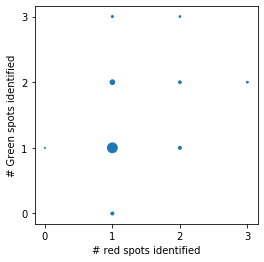

In [6]:
plotOccurence(CLLst)
filterCLLst = selectSpotOccurence(CLLst, [1], [1])

In [7]:
var = pF.findVar([0,0,110,1.5, 700], 50)
print('standard deviation of G Channel is %.2f' % np.sqrt(var))
var = pF.findVar([0,0,114,2.4, 6000], 50)
print('standard deviation of G Channel is %.2f' % np.sqrt(var))

integral in variance has value -0.415736
standard deviation of G Channel is 5.44
integral in variance has value -0.238549
standard deviation of G Channel is 1.69


In [8]:
pxSize = 50
Gbg = []
Ybg = []
GA = []
YA = []
Gsigma = []
Ysigma = []
for loc in filterCLLst:
    Gbg.append(loc['G'].spotLst[0].bg)
    Ybg.append(loc['Y'].spotLst[0].bg)
    GA.append(loc['G'].spotLst[0].A * 2 * np.pi * loc['G'].spotLst[0].sigma)
    YA.append(loc['Y'].spotLst[0].A * 2 * np.pi * loc['Y'].spotLst[0].sigma)
    Gsigma.append(loc['G'].spotLst[0].sigma)
    Ysigma.append(loc['Y'].spotLst[0].sigma)

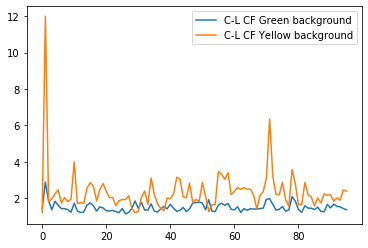

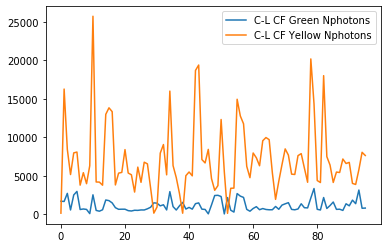

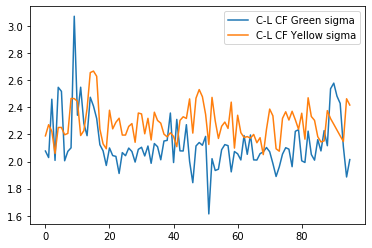

average photons in G: 1142 
average photons in Y: 7114
average sigma in G: 106.5 
average sigma in Y: 114.0
average bg in G: 1.49 
average bg in Y: 2.34


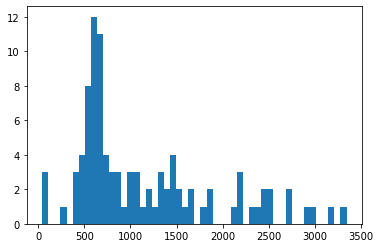

In [9]:
plt.plot(Gbg, label = 'C-L CF Green background')
plt.plot(Ybg, label = 'C-L CF Yellow background')
plt.legend()
plt.show()
plt.plot(GA, label = 'C-L CF Green Nphotons')
plt.plot(YA, label = 'C-L CF Yellow Nphotons')
plt.legend()
plt.show()
plt.plot(Gsigma, label = 'C-L CF Green sigma')
plt.plot(Ysigma, label = 'C-L CF Yellow sigma')
plt.legend()
plt.show()
print('average photons in G: %.0f \naverage photons in Y: %.0f' % (np.mean(GA), np.mean(YA)))
print('average sigma in G: %.1f \naverage sigma in Y: %.1f' % (np.mean(Gsigma) * pxSize, np.mean(Ysigma)*pxSize))
print('average bg in G: %.2f \naverage bg in Y: %.2f' % (np.mean(Gbg), np.mean(Ybg)))

_ = plt.hist(GA, bins = 50)

standard deviation of spots is 24.07 and 12.55


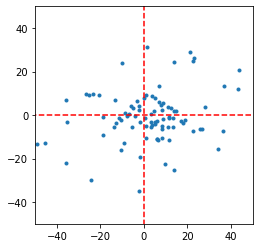

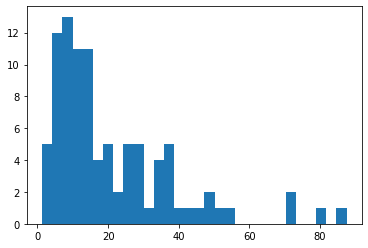

In [10]:
coords = plotSinglePair(filterCLLst, pxSize = 50)
_ = plt.hist(np.linalg.norm(coords, axis = 1), bins = 30)

# CF C-R data

### load previously processed data

In [11]:
wdir = r'N:\Singlem\singlem20-1\January\25_CR_origami_NV\Run1_CF\all'
fpath = os.path.join(wdir, 'SpotsObject.spots')
with open(fpath, 'rb') as spotsfile:
    CRLst = pickle.load(spotsfile)

### process data new

In [11]:
wdir = r'N:\Singlem\singlem20-1\January\25_CR_origami_NV\Run1_CF\all'
files = os.listdir(wdir)
options = optionsCluster(fitbg = 0, setbg = 0.2, ellipt_circ = 0)
CRLst = []
nfiles = 10
analyseCFdir(CRLst, options, nfiles = nfiles)

analysing image no. 0
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\CF_run1\\all\\header\\Overview_Pos_y-0.00111784_spot_72.txt'
number of records is 35664


K:\vanderVoortN\FRC\Code\GaussAnalysisPipeline.py:293: RuntimeWarning: divide by zero encountered in true_divide
  plt.imshow(model - image *( 1 + np.log(model / image)), cmap = 'hot')
K:\vanderVoortN\FRC\Code\GaussAnalysisPipeline.py:293: RuntimeWarning: invalid value encountered in multiply
  plt.imshow(model - image *( 1 + np.log(model / image)), cmap = 'hot')
K:\vanderVoortN\FRC\Code\GaussAnalysisPipeline.py:271: UserWarning: No contour levels were found within the data range.
  plt.contour(model, levels = np.array([0.01, 0.5, 1, 3, 5, 10, 20, 30, 40], dtype = np.double))
K:\vanderVoortN\FRC\Code\GaussAnalysisPipeline.py:293: RuntimeWarning: invalid value encountered in log
  plt.imshow(model - image *( 1 + np.log(model / image)), cmap = 'hot')
K:\vanderVoortN\FRC\Code\GaussAnalysisPipeline.py:136: RuntimeWarning: invalid value encountered in greater
  isNoJunkIstar = twoIstar > junkIstar
K:\vanderVoortN\FRC\Code\GaussAnalysisPipeline.py:141: RuntimeWarning: invalid value encounter

[{'G': <GaussAnalysisPipeline.Channel at 0x1c2664a4988>,
  'Y': <GaussAnalysisPipeline.Channel at 0x1c26628bc48>}]

<Figure size 432x288 with 0 Axes>

### Analysis

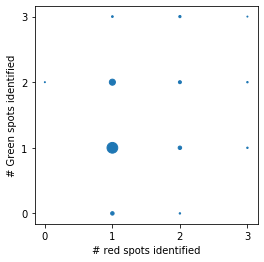

In [12]:
plotOccurence(CRLst)
filterCRLst = selectSpotOccurence(CRLst, [1], [1])

In [13]:
pxSize = 50
Gbg = []
Ybg = []
GA = []
YA = []
Gsigma = []
Ysigma = []
for loc in filterCRLst:
    Gbg.append(loc['G'].spotLst[0].bg)
    Ybg.append(loc['Y'].spotLst[0].bg)
    GA.append(loc['G'].spotLst[0].A * 2 * np.pi * loc['G'].spotLst[0].sigma)
    YA.append(loc['Y'].spotLst[0].A * 2 * np.pi * loc['Y'].spotLst[0].sigma)
    Gsigma.append(loc['G'].spotLst[0].sigma)
    Ysigma.append(loc['Y'].spotLst[0].sigma)

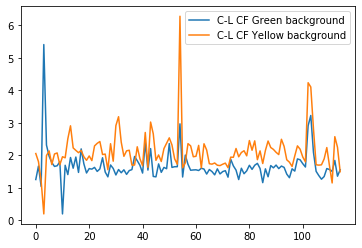

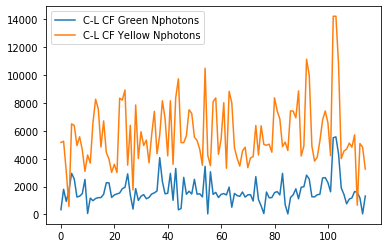

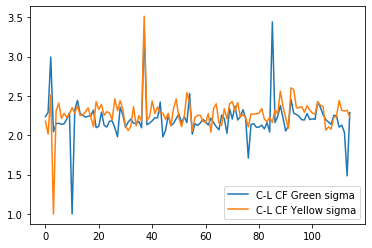

average photons in G: 1645 
average photons in Y: 5753
average sigma in G: 110.1 
average sigma in Y: 113.9
average bg in G: 1.67 
average bg in Y: 2.11


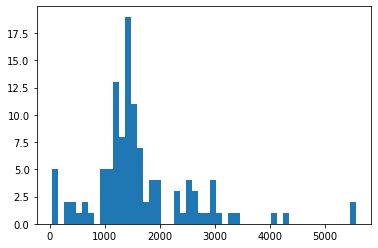

In [14]:
plt.plot(Gbg, label = 'C-L CF Green background')
plt.plot(Ybg, label = 'C-L CF Yellow background')
plt.legend()
plt.show()
plt.plot(GA, label = 'C-L CF Green Nphotons')
plt.plot(YA, label = 'C-L CF Yellow Nphotons')
plt.legend()
plt.show()
plt.plot(Gsigma, label = 'C-L CF Green sigma')
plt.plot(Ysigma, label = 'C-L CF Yellow sigma')
plt.legend()
plt.show()
print('average photons in G: %.0f \naverage photons in Y: %.0f' % (np.mean(GA), np.mean(YA)))
print('average sigma in G: %.1f \naverage sigma in Y: %.1f' % (np.mean(Gsigma) * pxSize, np.mean(Ysigma)*pxSize))
print('average bg in G: %.2f \naverage bg in Y: %.2f' % (np.mean(Gbg), np.mean(Ybg)))

_ = plt.hist(GA, bins = 50)

In [124]:
var = pF.findVar([0,0,110,1.7, 1600], 50)
print('standard deviation of G Channel is %.2f' % np.sqrt(var))
var = pF.findVar([0,0,114,2.1, 5000], 50)
print('standard deviation of Y Channel is %.2f' % np.sqrt(var))

integral in variance has value -0.318628
standard deviation of G Channel is 3.33
integral in variance has value -0.227795
standard deviation of G Channel is 1.83


standard deviation of spots is 18.99 and 18.17


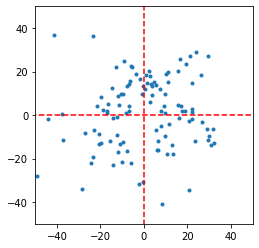

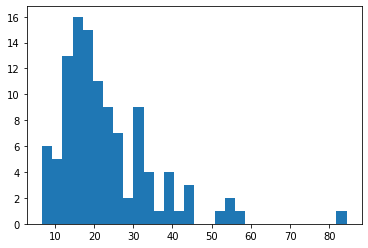

In [15]:
coords = plotSinglePair(filterCRLst, pxSize = 50)
_ = plt.hist(np.linalg.norm(coords, axis = 1), bins = 30)

In [27]:
filterCRLst[0]['G'].spotLst[0].eps

0.7678770926320612

# STED C-L data

### merge PTU files

In [ ]:
path = os.path.join(r'N:\Singlem\singlem20-1\January\24_CL_origami_NV\STED_run2', '')
savedir = os.path.join(path, 'all')
mergePTUfiles(path, savedir)

### Analyze data new

In [169]:
wdir = r'N:\Singlem\singlem20-1\January\24_CL_origami_NV\STED_run2\all'
files = os.listdir(wdir)[:1908]
options = optionsCluster(fitbg = 0, setbg = 0.2, ellipt_circ = 1)
STEDCLLst1 = []
analyseSTEDdir(STEDCLLst1, options, wdir, files, Ggate = 0, Ygate = 29, outname = 'STEDCL_file1-1908.spots')

analysing image no. 0
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00037396_spot_0_x_-50.0_y_-163.0.txt'
number of records is 34087
analysing image no. 1
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00037396_spot_1_x_-175.0_y_-129.0.txt'
number of records is 32495
analysing image no. 2
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00037396_spot_2_x_18.0_y_-35.0.txt'
number of records is 33516
analysing image no. 3
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00037396_spot_3_x_140.0_y_24.0.txt'
number of records is 32213
analysing image no. 4
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00037396

analysing image no. 40
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00037396_spot_39_x_-135.0_y_141.0.txt'
number of records is 37444
analysing image no. 41
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00037396_spot_40_x_-34.0_y_149.0.txt'
number of records is 37138
analysing image no. 42
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00037396_spot_41_x_-142.0_y_162.0.txt'
number of records is 30761
analysing image no. 43
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00039596_spot_0_x_195.0_y_-188.0.txt'
number of records is 33472
analysing image no. 44
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-

analysing image no. 78
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00039596_spot_35_x_-156.0_y_-39.0.txt'
number of records is 32281
analysing image no. 79
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00039596_spot_36_x_112.0_y_-12.0.txt'
number of records is 31523
analysing image no. 80
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00039596_spot_37_x_-24.0_y_-8.0.txt'
number of records is 30873
analysing image no. 81
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00039596_spot_38_x_-25.0_y_-6.0.txt'
number of records is 31372
analysing image no. 82
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.0

analysing image no. 117
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00041796_spot_17_x_-137.0_y_-141.0.txt'
number of records is 33726
analysing image no. 118
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00041796_spot_18_x_-125.0_y_-140.0.txt'
number of records is 32558
analysing image no. 119
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00041796_spot_19_x_-198.0_y_-139.0.txt'
number of records is 32251
analysing image no. 120
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00041796_spot_20_x_-123.0_y_-138.0.txt'
number of records is 37200
analysing image no. 121
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOver

analysing image no. 155
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00041796_spot_55_x_-3.0_y_86.0.txt'
number of records is 30450
analysing image no. 156
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00041796_spot_56_x_-5.0_y_88.0.txt'
number of records is 31564
analysing image no. 157
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00041796_spot_57_x_133.0_y_92.0.txt'
number of records is 39709
analysing image no. 158
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00041796_spot_58_x_-47.0_y_95.0.txt'
number of records is 38463
analysing image no. 159
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.0

analysing image no. 192
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00043996_spot_19_x_-59.0_y_-111.0.txt'
number of records is 33298
analysing image no. 193
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00043996_spot_20_x_-130.0_y_-108.0.txt'
number of records is 30828
analysing image no. 194
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00043996_spot_21_x_-132.0_y_-106.0.txt'
number of records is 32411
ROI touches image borders, skipping
analysing image no. 195
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00043996_spot_22_x_-93.0_y_-104.0.txt'
number of records is 32230
analysing image no. 196
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_N

analysing image no. 230
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00043996_spot_57_x_121.0_y_163.0.txt'
number of records is 31225
analysing image no. 231
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00043996_spot_58_x_-147.0_y_165.0.txt'
number of records is 30127
analysing image no. 232
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00043996_spot_59_x_193.0_y_175.0.txt'
number of records is 30384
analysing image no. 233
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00043996_spot_60_x_194.0_y_177.0.txt'
number of records is 31771
analysing image no. 234
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Po

analysing image no. 269
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00046196_spot_33_x_143.0_y_-36.0.txt'
number of records is 34033
analysing image no. 270
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00046196_spot_34_x_64.0_y_-34.0.txt'
number of records is 30347
analysing image no. 271
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00046196_spot_35_x_28.0_y_-19.0.txt'
number of records is 31127
analysing image no. 272
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00046196_spot_36_x_184.0_y_-19.0.txt'
number of records is 30157
analysing image no. 273
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y

analysing image no. 308
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00052796_spot_6_x_105.0_y_157.0.txt'
number of records is 31597
analysing image no. 309
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00052796_spot_7_x_108.0_y_158.0.txt'
number of records is 31190
analysing image no. 310
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00052796_spot_8_x_106.0_y_159.0.txt'
number of records is 31403
analysing image no. 311
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00052796_spot_9_x_-135.0_y_186.0.txt'
number of records is 30431
analysing image no. 312
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-

analysing image no. 347
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00061596_spot_0_x_-74.0_y_-195.0.txt'
number of records is 34665
analysing image no. 348
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00061596_spot_1_x_-71.0_y_-194.0.txt'
number of records is 33484
analysing image no. 349
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00061596_spot_2_x_-161.0_y_-94.0.txt'
number of records is 33351
analysing image no. 350
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00061596_spot_3_x_134.0_y_-52.0.txt'
number of records is 37562
analysing image no. 351
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_

analysing image no. 386
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00061596_spot_39_x_55.0_y_106.0.txt'
number of records is 30558
analysing image no. 387
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00061596_spot_40_x_55.0_y_110.0.txt'
number of records is 30168
analysing image no. 388
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00061596_spot_41_x_-173.0_y_117.0.txt'
number of records is 30954
analysing image no. 389
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00061596_spot_42_x_-172.0_y_120.0.txt'
number of records is 30985
analysing image no. 390
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos

analysing image no. 426
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00063796_spot_27_x_-177.0_y_-21.0.txt'
number of records is 30948
analysing image no. 427
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00063796_spot_28_x_27.0_y_-2.0.txt'
number of records is 32825
analysing image no. 428
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00063796_spot_29_x_30.0_y_-2.0.txt'
number of records is 31928
analysing image no. 429
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00063796_spot_30_x_-31.0_y_5.0.txt'
number of records is 32009
analysing image no. 430
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.

analysing image no. 464
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00065996_spot_20_x_-128.0_y_-44.0.txt'
number of records is 34079
analysing image no. 465
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00065996_spot_21_x_60.0_y_-23.0.txt'
number of records is 31363
analysing image no. 466
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00065996_spot_22_x_164.0_y_-10.0.txt'
number of records is 31928
ROI touches image borders, skipping
analysing image no. 467
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00065996_spot_23_x_35.0_y_-3.0.txt'
number of records is 31586
analysing image no. 468
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_

analysing image no. 502
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00068196_spot_31_x_-190.0_y_20.0.txt'
number of records is 30412
analysing image no. 503
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00068196_spot_32_x_-188.0_y_23.0.txt'
number of records is 30308
analysing image no. 504
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00068196_spot_33_x_91.0_y_56.0.txt'
number of records is 31801
ROI touches image borders, skipping
analysing image no. 505
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00068196_spot_34_x_-130.0_y_58.0.txt'
number of records is 31183
analysing image no. 506
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_

analysing image no. 540
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00070396_spot_14_x_-80.0_y_-169.0.txt'
number of records is 32273
analysing image no. 541
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00070396_spot_15_x_-82.0_y_-166.0.txt'
number of records is 31442
analysing image no. 542
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00070396_spot_16_x_-98.0_y_-155.0.txt'
number of records is 31248
analysing image no. 543
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00070396_spot_17_x_-97.0_y_-153.0.txt'
number of records is 31113
analysing image no. 544
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview

analysing image no. 579
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00070396_spot_53_x_7.0_y_66.0.txt'
number of records is 34453
analysing image no. 580
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00070396_spot_54_x_6.0_y_68.0.txt'
number of records is 32369
analysing image no. 581
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00070396_spot_55_x_-71.0_y_83.0.txt'
number of records is 32411
analysing image no. 582
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00070396_spot_56_x_-195.0_y_85.0.txt'
number of records is 33250
analysing image no. 583
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00

K:\vanderVoortN\FRC\Code\GaussAnalysisPipeline.py:206: RuntimeWarning: overflow encountered in double_scalars
  brightness[i] = params[2] * factor
K:\vanderVoortN\FRC\Code\GaussAnalysisPipeline.py:208: RuntimeWarning: overflow encountered in double_scalars
  brightness[i] = params[8] * factor
K:\vanderVoortN\FRC\Code\GaussAnalysisPipeline.py:210: RuntimeWarning: overflow encountered in double_scalars
  brightness[i] = params[11] * factor


analysing image no. 600
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00072596_spot_12_x_-37.0_y_-31.0.txt'
number of records is 32100
analysing image no. 601
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00072596_spot_13_x_-38.0_y_-28.0.txt'
number of records is 33171
analysing image no. 602
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00072596_spot_14_x_-125.0_y_-17.0.txt'
number of records is 31786
analysing image no. 603
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00072596_spot_15_x_-125.0_y_-14.0.txt'
number of records is 29689
ROI touches image borders, skipping
analysing image no. 604
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\S

analysing image no. 638
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00074796_spot_25_x_-33.0_y_-67.0.txt'
number of records is 32048
analysing image no. 639
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00074796_spot_26_x_-196.0_y_-66.0.txt'
number of records is 31709
analysing image no. 640
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00074796_spot_27_x_-35.0_y_-65.0.txt'
number of records is 31167
analysing image no. 641
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00074796_spot_28_x_-160.0_y_-24.0.txt'
number of records is 30774
analysing image no. 642
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_P

analysing image no. 676
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00076996_spot_15_x_-75.0_y_-15.0.txt'
number of records is 32144
analysing image no. 677
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00076996_spot_16_x_-74.0_y_-13.0.txt'
number of records is 32180
analysing image no. 678
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00076996_spot_17_x_-47.0_y_21.0.txt'
number of records is 31449
analysing image no. 679
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00076996_spot_18_x_-45.0_y_22.0.txt'
number of records is 34994
analysing image no. 680
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y

analysing image no. 714
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00079196_spot_17_x_-36.0_y_-107.0.txt'
number of records is 29391
ROI touches image borders, skipping
analysing image no. 715
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00079196_spot_18_x_-162.0_y_-103.0.txt'
number of records is 29379
analysing image no. 716
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00079196_spot_19_x_65.0_y_-102.0.txt'
number of records is 31354
analysing image no. 717
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00079196_spot_20_x_-164.0_y_-101.0.txt'
number of records is 33118
analysing image no. 718
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV

analysing image no. 751
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00079196_spot_54_x_-97.0_y_153.0.txt'
number of records is 31490
analysing image no. 752
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00079196_spot_55_x_162.0_y_166.0.txt'
number of records is 31173
analysing image no. 753
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00079196_spot_56_x_162.0_y_169.0.txt'
number of records is 31120
analysing image no. 754
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00079196_spot_57_x_-20.0_y_171.0.txt'
number of records is 31275
analysing image no. 755
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos

analysing image no. 789
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00083596_spot_34_x_-199.0_y_-142.0.txt'
number of records is 51439
analysing image no. 790
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00083596_spot_35_x_-190.0_y_-142.0.txt'
number of records is 60038
ROI touches image borders, skipping
analysing image no. 791
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00083596_spot_36_x_-198.0_y_-139.0.txt'
number of records is 47788
analysing image no. 792
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00083596_spot_37_x_-192.0_y_-137.0.txt'
number of records is 43432
analysing image no. 793
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami

analysing image no. 827
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00083596_spot_72_x_39.0_y_137.0.txt'
number of records is 31048
analysing image no. 828
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00083596_spot_73_x_39.0_y_139.0.txt'
number of records is 31468
analysing image no. 829
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00083596_spot_74_x_-116.0_y_173.0.txt'
number of records is 32010
analysing image no. 830
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00083596_spot_75_x_-144.0_y_194.0.txt'
number of records is 29753
analysing image no. 831
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos

analysing image no. 865
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00092396_spot_1_x_-86.0_y_-162.0.txt'
number of records is 31843
analysing image no. 866
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00092396_spot_2_x_2.0_y_-99.0.txt'
number of records is 31844
analysing image no. 867
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00092396_spot_3_x_-129.0_y_0.0.txt'
number of records is 33805
analysing image no. 868
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00092396_spot_4_x_-36.0_y_121.0.txt'
number of records is 32871
analysing image no. 869
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.0

analysing image no. 904
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00092396_spot_40_x_-182.0_y_144.0.txt'
number of records is 30360
analysing image no. 905
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00092396_spot_41_x_-181.0_y_148.0.txt'
number of records is 29901
ROI touches image borders, skipping
analysing image no. 906
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00092396_spot_42_x_-184.0_y_150.0.txt'
number of records is 29562
analysing image no. 907
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00092396_spot_43_x_169.0_y_157.0.txt'
number of records is 32456
analysing image no. 908
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\

analysing image no. 942
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00094596_spot_34_x_-10.0_y_95.0.txt'
number of records is 29585
ROI touches image borders, skipping
analysing image no. 943
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00094596_spot_35_x_-9.0_y_97.0.txt'
number of records is 31675
analysing image no. 944
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00094596_spot_36_x_-115.0_y_103.0.txt'
number of records is 30709
analysing image no. 945
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00094596_spot_37_x_-153.0_y_105.0.txt'
number of records is 33094
analysing image no. 946
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED

analysing image no. 979
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00094596_spot_71_x_156.0_y_151.0.txt'
number of records is 37664
ROI touches image borders, skipping
analysing image no. 980
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00094596_spot_72_x_158.0_y_151.0.txt'
number of records is 40464
ROI touches image borders, skipping
analysing image no. 981
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00094596_spot_73_x_175.0_y_151.0.txt'
number of records is 37694
ROI touches image borders, skipping
analysing image no. 982
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00094596_spot_74_x_164.0_y_152.0.txt'
number of records is 35734
ROI touches image borders, skipping


analysing image no. 1017
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00096796_spot_21_x_-16.0_y_-47.0.txt'
number of records is 31193
analysing image no. 1018
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00096796_spot_22_x_-143.0_y_-45.0.txt'
number of records is 30924
analysing image no. 1019
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00096796_spot_23_x_-141.0_y_-45.0.txt'
number of records is 31200
analysing image no. 1020
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00096796_spot_24_x_-16.0_y_-45.0.txt'
number of records is 30563
analysing image no. 1021
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverv

analysing image no. 1056
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00098996_spot_10_x_17.0_y_-185.0.txt'
number of records is 31013
analysing image no. 1057
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00098996_spot_11_x_15.0_y_-183.0.txt'
number of records is 31221
analysing image no. 1058
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00098996_spot_12_x_56.0_y_-162.0.txt'
number of records is 36954
analysing image no. 1059
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00098996_spot_13_x_44.0_y_-151.0.txt'
number of records is 34831
analysing image no. 1060
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOvervie

analysing image no. 1094
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00098996_spot_48_x_-15.0_y_75.0.txt'
number of records is 31600
analysing image no. 1095
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00098996_spot_49_x_-14.0_y_75.0.txt'
number of records is 30215
analysing image no. 1096
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00098996_spot_50_x_96.0_y_88.0.txt'
number of records is 31370
analysing image no. 1097
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00098996_spot_51_x_123.0_y_91.0.txt'
number of records is 31066
analysing image no. 1098
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos

analysing image no. 1132
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00103396_spot_16_x_97.0_y_-160.0.txt'
number of records is 33474
analysing image no. 1133
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00103396_spot_17_x_-33.0_y_-159.0.txt'
number of records is 32438
analysing image no. 1134
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00103396_spot_18_x_-35.0_y_-157.0.txt'
number of records is 31442
ROI touches image borders, skipping
analysing image no. 1135
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00103396_spot_19_x_-79.0_y_-156.0.txt'
number of records is 31401
analysing image no. 1136
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami

analysing image no. 1170
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00103396_spot_54_x_12.0_y_117.0.txt'
number of records is 34258
analysing image no. 1171
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00103396_spot_55_x_126.0_y_154.0.txt'
number of records is 34622
analysing image no. 1172
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00103396_spot_56_x_-96.0_y_164.0.txt'
number of records is 31207
analysing image no. 1173
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00105596_spot_0_x_14.0_y_-180.0.txt'
number of records is 35893
analysing image no. 1174
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_

analysing image no. 1209
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00105596_spot_36_x_-190.0_y_69.0.txt'
number of records is 30402
analysing image no. 1210
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00105596_spot_37_x_184.0_y_93.0.txt'
number of records is 29926
analysing image no. 1211
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00105596_spot_38_x_-169.0_y_119.0.txt'
number of records is 31078
analysing image no. 1212
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00105596_spot_39_x_-170.0_y_121.0.txt'
number of records is 29362
ROI touches image borders, skipping
analysing image no. 1213
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_N

analysing image no. 1247
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00107796_spot_26_x_44.0_y_-88.0.txt'
number of records is 31274
analysing image no. 1248
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00107796_spot_27_x_42.0_y_-87.0.txt'
number of records is 31505
analysing image no. 1249
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00107796_spot_28_x_-44.0_y_-86.0.txt'
number of records is 36145
analysing image no. 1250
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00107796_spot_29_x_-46.0_y_-85.0.txt'
number of records is 33571
analysing image no. 1251
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_

analysing image no. 1286
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00109996_spot_14_x_-57.0_y_-136.0.txt'
number of records is 32265
ROI touches image borders, skipping
analysing image no. 1287
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00109996_spot_15_x_35.0_y_-99.0.txt'
number of records is 29829
ROI touches image borders, skipping
analysing image no. 1288
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00109996_spot_16_x_34.0_y_-97.0.txt'
number of records is 31084
analysing image no. 1289
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00109996_spot_17_x_-5.0_y_-81.0.txt'
number of records is 30336
analysing image no. 1290
header dir already exists
b'N:\\Singlem\\sing

analysing image no. 1324
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00112196_spot_0_x_-44.0_y_-180.0.txt'
number of records is 36191
analysing image no. 1325
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00112196_spot_1_x_-46.0_y_-178.0.txt'
number of records is 34455
analysing image no. 1326
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00112196_spot_2_x_-108.0_y_-113.0.txt'
number of records is 32776
analysing image no. 1327
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00112196_spot_3_x_-6.0_y_53.0.txt'
number of records is 31795
analysing image no. 1328
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_

analysing image no. 1362
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00112196_spot_38_x_-52.0_y_86.0.txt'
number of records is 32977
analysing image no. 1363
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00112196_spot_39_x_79.0_y_107.0.txt'
number of records is 30832
analysing image no. 1364
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00112196_spot_40_x_-178.0_y_121.0.txt'
number of records is 30874
analysing image no. 1365
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00112196_spot_41_x_-56.0_y_136.0.txt'
number of records is 30363
analysing image no. 1366
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview

analysing image no. 1400
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00114396_spot_27_x_-10.0_y_39.0.txt'
number of records is 31227
analysing image no. 1401
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00114396_spot_28_x_-181.0_y_41.0.txt'
number of records is 32571
analysing image no. 1402
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00114396_spot_29_x_-10.0_y_41.0.txt'
number of records is 30444
analysing image no. 1403
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00114396_spot_30_x_113.0_y_51.0.txt'
number of records is 30604
analysing image no. 1404
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_P

analysing image no. 1438
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00116596_spot_28_x_-198.0_y_-87.0.txt'
number of records is 31094
analysing image no. 1439
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00116596_spot_29_x_187.0_y_-68.0.txt'
number of records is 30908
analysing image no. 1440
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00116596_spot_30_x_-43.0_y_-65.0.txt'
number of records is 32597
analysing image no. 1441
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00116596_spot_31_x_29.0_y_-62.0.txt'
number of records is 31227
analysing image no. 1442
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOvervie

analysing image no. 1476
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00116596_spot_66_x_141.0_y_64.0.txt'
number of records is 31698
analysing image no. 1477
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00116596_spot_67_x_-82.0_y_72.0.txt'
number of records is 32450
analysing image no. 1478
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00116596_spot_68_x_-83.0_y_74.0.txt'
number of records is 32183
analysing image no. 1479
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00116596_spot_69_x_37.0_y_74.0.txt'
number of records is 31784
analysing image no. 1480
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos

analysing image no. 1514
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00118796_spot_15_x_-24.0_y_-149.0.txt'
number of records is 30547
analysing image no. 1515
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00118796_spot_16_x_-26.0_y_-147.0.txt'
number of records is 30776
analysing image no. 1516
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00118796_spot_17_x_-24.0_y_-147.0.txt'
number of records is 34315
analysing image no. 1517
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00118796_spot_18_x_-138.0_y_-138.0.txt'
number of records is 33053
analysing image no. 1518
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOv

analysing image no. 1552
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00118796_spot_53_x_58.0_y_102.0.txt'
number of records is 35837
analysing image no. 1553
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00118796_spot_54_x_100.0_y_138.0.txt'
number of records is 33660
analysing image no. 1554
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00118796_spot_55_x_99.0_y_140.0.txt'
number of records is 30834
analysing image no. 1555
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00118796_spot_56_x_-36.0_y_173.0.txt'
number of records is 32316
analysing image no. 1556
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_

analysing image no. 1589
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00010995999999999988_spot_28_x_-62.0_y_-126.0.txt'
number of records is 30522
ROI touches image borders, skipping
analysing image no. 1590
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00010995999999999988_spot_29_x_-59.0_y_-126.0.txt'
number of records is 29593
analysing image no. 1591
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00010995999999999988_spot_30_x_-62.0_y_-124.0.txt'
number of records is 29556
analysing image no. 1592
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00010995999999999988_spot_31_x_70.0_y_-105.0.txt'
number of records is 31874
not a .ptu file, skipping
analysing image no. 1594
he

analysing image no. 1627
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00010995999999999988_spot_64_x_-59.0_y_181.0.txt'
number of records is 31645
analysing image no. 1628
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00013195999999999998_spot_0_x_-56.0_y_-194.0.txt'
number of records is 34899
analysing image no. 1629
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00013195999999999998_spot_1_x_-47.0_y_-167.0.txt'
number of records is 31625
analysing image no. 1630
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00013195999999999998_spot_2_x_0.0_y_-117.0.txt'
number of records is 30390
analysing image no. 1631
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_

analysing image no. 1663
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00013195999999999998_spot_35_x_55.0_y_-5.0.txt'
number of records is 31945
analysing image no. 1664
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00013195999999999998_spot_36_x_8.0_y_-3.0.txt'
number of records is 33155
analysing image no. 1665
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00013195999999999998_spot_37_x_9.0_y_-1.0.txt'
number of records is 33017
analysing image no. 1666
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00013195999999999998_spot_38_x_-191.0_y_21.0.txt'
number of records is 31757
analysing image no. 1667
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origam

ROI touches image borders, skipping
analysing image no. 1699
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00015395999999999986_spot_11_x_56.0_y_-146.0.txt'
number of records is 29708
analysing image no. 1700
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00015395999999999986_spot_12_x_-168.0_y_-144.0.txt'
number of records is 31923
analysing image no. 1701
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00015395999999999986_spot_13_x_-167.0_y_-142.0.txt'
number of records is 31631
analysing image no. 1702
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00015395999999999986_spot_14_x_-156.0_y_-102.0.txt'
number of records is 31504
analysing image no. 1703
header dir already exists

number of records is 29948
ROI touches image borders, skipping
analysing image no. 1735
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00015395999999999986_spot_47_x_155.0_y_85.0.txt'
number of records is 31203
analysing image no. 1736
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00015395999999999986_spot_48_x_153.0_y_86.0.txt'
number of records is 30779
analysing image no. 1737
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00015395999999999986_spot_49_x_98.0_y_90.0.txt'
number of records is 31355
analysing image no. 1738
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00015395999999999986_spot_50_x_98.0_y_93.0.txt'
number of records is 31654
analysing image no. 1739
header dir

analysing image no. 1771
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00017595999999999996_spot_14_x_-23.0_y_-137.0.txt'
number of records is 32194
analysing image no. 1772
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00017595999999999996_spot_15_x_-24.0_y_-134.0.txt'
number of records is 32596
analysing image no. 1773
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00017595999999999996_spot_16_x_79.0_y_-126.0.txt'
number of records is 31435
analysing image no. 1774
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00017595999999999996_spot_17_x_-20.0_y_-125.0.txt'
number of records is 32053
analysing image no. 1775
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\2

analysing image no. 1808
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00017595999999999996_spot_51_x_-114.0_y_172.0.txt'
number of records is 30245
analysing image no. 1809
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00017595999999999996_spot_52_x_-88.0_y_172.0.txt'
number of records is 33853
analysing image no. 1810
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00017595999999999996_spot_53_x_-89.0_y_174.0.txt'
number of records is 31004
analysing image no. 1811
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00019795999999999985_spot_0_x_-129.0_y_-170.0.txt'
number of records is 33023
analysing image no. 1812
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24

analysing image no. 1843
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00019795999999999985_spot_32_x_-68.0_y_-48.0.txt'
number of records is 30693
analysing image no. 1844
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00019795999999999985_spot_33_x_-68.0_y_-47.0.txt'
number of records is 30580
analysing image no. 1845
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00019795999999999985_spot_34_x_-14.0_y_-38.0.txt'
number of records is 31395
analysing image no. 1846
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00019795999999999985_spot_35_x_130.0_y_-31.0.txt'
number of records is 29552
ROI touches image borders, skipping
analysing image no. 1847
header dir already exists
b'N:\

analysing image no. 1879
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00021995999999999995_spot_6_x_-131.0_y_173.0.txt'
number of records is 29865
ROI touches image borders, skipping
analysing image no. 1880
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00021995999999999995_spot_7_x_89.0_y_177.0.txt'
number of records is 32134
analysing image no. 1881
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00021995999999999995_spot_8_x_91.0_y_178.0.txt'
number of records is 31815
analysing image no. 1882
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00021995999999999995_spot_9_x_89.0_y_179.0.txt'
number of records is 31183
analysing image no. 1883
header dir already exists
b'N:\\Singl

[{'G': <GaussAnalysisPipeline.Channel at 0x11a0e8686c8>,
  'Y': <GaussAnalysisPipeline.Channel at 0x11a0e567b88>},
 {'G': <GaussAnalysisPipeline.Channel at 0x11a0eecb3c8>,
  'Y': <GaussAnalysisPipeline.Channel at 0x11a0e7cfa88>},
 {'G': <GaussAnalysisPipeline.Channel at 0x11a0ec172c8>,
  'Y': <GaussAnalysisPipeline.Channel at 0x11a0e6bd508>},
 {'G': <GaussAnalysisPipeline.Channel at 0x11a03081a08>,
  'Y': <GaussAnalysisPipeline.Channel at 0x11a0ed57548>},
 {'G': <GaussAnalysisPipeline.Channel at 0x11a0da517c8>,
  'Y': <GaussAnalysisPipeline.Channel at 0x11a0e6a18c8>},
 {'G': <GaussAnalysisPipeline.Channel at 0x11a65672dc8>,
  'Y': <GaussAnalysisPipeline.Channel at 0x11a0d98afc8>},
 {'G': <GaussAnalysisPipeline.Channel at 0x11a0eb4a388>,
  'Y': <GaussAnalysisPipeline.Channel at 0x11a052ce9c8>},
 {'G': <GaussAnalysisPipeline.Channel at 0x11a0e6a1fc8>,
  'Y': <GaussAnalysisPipeline.Channel at 0x11a0e59dbc8>},
 {'G': <GaussAnalysisPipeline.Channel at 0x11a0ea341c8>,
  'Y': <GaussAnalysisPi

<Figure size 432x288 with 0 Axes>

### load previously analysed data

In [ ]:
wdir = r'N:\Singlem\singlem20-1\January\24_CL_origami_NV\STED_run2\all'
fpath = os.path.join(wdir, 'STEDCL.spots')
with open(fpath, 'rb') as spotsfile:
    STEDCLLst = pickle.load(spotsfile)

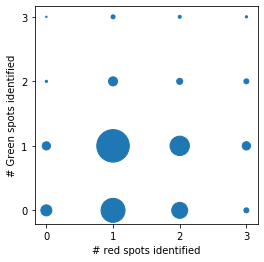

In [190]:
plotOccurence(STEDCLLst)
filterCLLst = selectSpotOccurence(STEDCLLst, [1], [1])

In [213]:
pxSize = 10
Gbg = []
Ybg = []
GA = []
YA = []
Gsigma = []
Ysigma = []
for loc in filterCLLst:
    Gbg.append(loc['G'].spotLst[0].bg)
    Ybg.append(loc['Y'].spotLst[0].bg)
    GA.append(loc['G'].spotLst[0].A * 2 * np.pi * loc['G'].spotLst[0].sigma)
    YA.append(loc['Y'].spotLst[0].A * 2 * np.pi * loc['Y'].spotLst[0].sigma)
    Gsigma.append(loc['G'].spotLst[0].sigma)
    Ysigma.append(loc['Y'].spotLst[0].sigma)

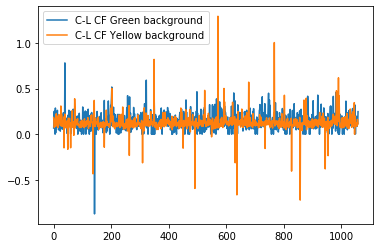

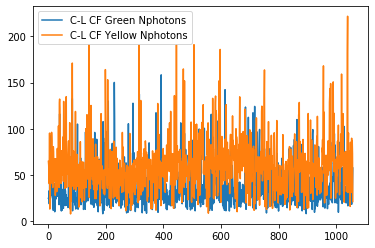

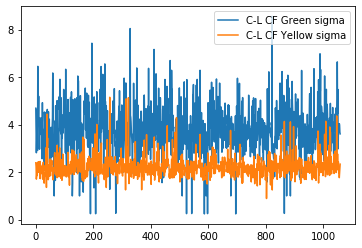

average photons in G: 37 
average photons in Y: 61
average sigma in G: 37.9 
average sigma in Y: 22.3
average bg in G: 0.15 
average bg in Y: 0.12


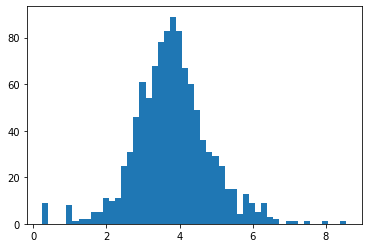

In [218]:
plt.plot(Gbg, label = 'C-L CF Green background')
plt.plot(Ybg, label = 'C-L CF Yellow background')
plt.legend()
plt.show()
plt.plot(GA, label = 'C-L CF Green Nphotons')
plt.plot(YA, label = 'C-L CF Yellow Nphotons')
plt.legend()
plt.show()
plt.plot(Gsigma, label = 'C-L CF Green sigma')
plt.plot(Ysigma, label = 'C-L CF Yellow sigma')
plt.legend()
plt.show()
print('average photons in G: %.0f \naverage photons in Y: %.0f' % (np.mean(GA), np.mean(YA)))
print('average sigma in G: %.1f \naverage sigma in Y: %.1f' % (np.mean(Gsigma) * pxSize, np.mean(Ysigma)*pxSize))
print('average bg in G: %.2f \naverage bg in Y: %.2f' % (np.mean(Gbg), np.mean(Ybg)))

_ = plt.hist(Gsigma, bins = 50)

In [193]:
var = pF.findVar([0,0,38,0.15, 41], 37)
print('standard deviation of G Channel is %.2f' % np.sqrt(var))
var = pF.findVar([0,0,22,0.1, 70], 61)
print('standard deviation of Y Channel is %.2f' % np.sqrt(var))

integral in variance has value -0.063336
standard deviation of G Channel is 6.13
integral in variance has value -0.004979
standard deviation of Y Channel is 2.64


standard deviation of spots is 11.06 and 10.41


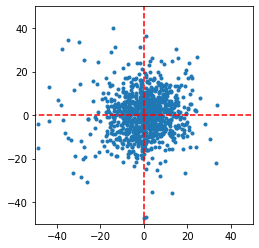

[-6.56637343e-03  9.13520774e+00  1.80363978e+03  2.41923739e+00]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


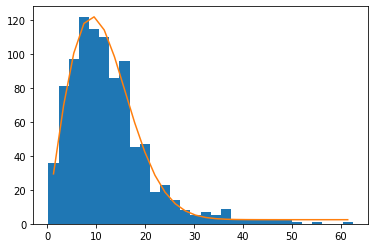

In [194]:
coords = plotSinglePair(filterCLLst, pxSize = pxSize)
counts, bin_edges, _ = plt.hist(np.linalg.norm(coords, axis = 1), bins = 30)

Nbins = bin_edges.shape[0] - 1
bins = np.zeros(Nbins)
for i in range(Nbins):
    bins[i] = (bin_edges[i] + bin_edges[i + 1]) / 2

params0 = [15, 3, 500, 10]
fitres = minimize(logLikelihood1D, params0, args = (ncChidistr, bins, counts), 
                  method = 'Nelder-Mead',
                  options = {'maxiter':10000,'maxfev':10000, 'fatol':1e-5})
plt.plot(bins, ncChidistr(bins, *fitres.x))
print(fitres.x)

In [205]:
np.sqrt(2*(6.13**2 + 2.62**2 + 2**2))

9.842895915328985

# STED C-R data

# merge PTU files

In [72]:
path = os.path.join(r'N:\Singlem\singlem20-1\January\25_CR_origami_NV\run2_STED', '')
savedir = os.path.join(path, 'all')
mergePTUfiles(path, savedir)

Overview_-0.00010995999999999988_numberSPOTS_65
Overview_-0.00013195999999999998_numberSPOTS_60
Overview_-0.00015395999999999986_numberSPOTS_69
Overview_-0.00017595999999999996_numberSPOTS_54
Overview_-0.00019795999999999985_numberSPOTS_62
Overview_-0.00021995999999999995_numberSPOTS_48
Overview_-0.00024195999999999994_numberSPOTS_66
Overview_-0.00026395999999999993_numberSPOTS_85
Overview_-0.0002859599999999999_numberSPOTS_63
Overview_-0.0003079599999999999_numberSPOTS_34
Overview_-0.0003299599999999999_numberSPOTS_51
Overview_-0.0003519599999999999_numberSPOTS_53
Overview_-0.00037396_numberSPOTS_42
Overview_-0.00039596_numberSPOTS_57
Overview_-0.00041796_numberSPOTS_73
Overview_-0.00043996_numberSPOTS_63
Overview_-0.00046196_numberSPOTS_53
Overview_-0.00048395999999999997_numberSPOTS_43
Overview_-0.00050596_numberSPOTS_13
Overview_-0.00052796_numberSPOTS_45
Overview_-0.0005499599999999999_numberSPOTS_64
Overview_-0.0005719599999999999_numberSPOTS_35
Overview_-0.0005939599999999999_nu

# Analyze data new

analysing image no. 0
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00037396_spot_0_x_-50.0_y_-163.0.txt'
number of records is 34087
analysing image no. 1
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00037396_spot_1_x_-175.0_y_-129.0.txt'
number of records is 32495
analysing image no. 2
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00037396_spot_2_x_18.0_y_-35.0.txt'
number of records is 33516
analysing image no. 3
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00037396_spot_3_x_140.0_y_24.0.txt'
number of records is 32213
analysing image no. 4
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00037396

analysing image no. 40
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00037396_spot_39_x_-135.0_y_141.0.txt'
number of records is 37444
analysing image no. 41
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00037396_spot_40_x_-34.0_y_149.0.txt'
number of records is 37138
analysing image no. 42
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00037396_spot_41_x_-142.0_y_162.0.txt'
number of records is 30761
analysing image no. 43
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00039596_spot_0_x_195.0_y_-188.0.txt'
number of records is 33472
analysing image no. 44
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-

analysing image no. 78
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00039596_spot_35_x_-156.0_y_-39.0.txt'
number of records is 32281
analysing image no. 79
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00039596_spot_36_x_112.0_y_-12.0.txt'
number of records is 31523
analysing image no. 80
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00039596_spot_37_x_-24.0_y_-8.0.txt'
number of records is 30873
analysing image no. 81
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00039596_spot_38_x_-25.0_y_-6.0.txt'
number of records is 31372
analysing image no. 82
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.0

analysing image no. 117
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00041796_spot_17_x_-137.0_y_-141.0.txt'
number of records is 33726
analysing image no. 118
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00041796_spot_18_x_-125.0_y_-140.0.txt'
number of records is 32558
analysing image no. 119
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00041796_spot_19_x_-198.0_y_-139.0.txt'
number of records is 32251
analysing image no. 120
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00041796_spot_20_x_-123.0_y_-138.0.txt'
number of records is 37200
analysing image no. 121
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOver

analysing image no. 155
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00041796_spot_55_x_-3.0_y_86.0.txt'
number of records is 30450
analysing image no. 156
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00041796_spot_56_x_-5.0_y_88.0.txt'
number of records is 31564
analysing image no. 157
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00041796_spot_57_x_133.0_y_92.0.txt'
number of records is 39709
analysing image no. 158
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00041796_spot_58_x_-47.0_y_95.0.txt'
number of records is 38463
analysing image no. 159
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.0

analysing image no. 192
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00043996_spot_19_x_-59.0_y_-111.0.txt'
number of records is 33298
analysing image no. 193
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00043996_spot_20_x_-130.0_y_-108.0.txt'
number of records is 30828
analysing image no. 194
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00043996_spot_21_x_-132.0_y_-106.0.txt'
number of records is 32411
ROI touches image borders, skipping
analysing image no. 195
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00043996_spot_22_x_-93.0_y_-104.0.txt'
number of records is 32230
analysing image no. 196
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_N

analysing image no. 230
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00043996_spot_57_x_121.0_y_163.0.txt'
number of records is 31225
analysing image no. 231
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00043996_spot_58_x_-147.0_y_165.0.txt'
number of records is 30127
analysing image no. 232
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00043996_spot_59_x_193.0_y_175.0.txt'
number of records is 30384
analysing image no. 233
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00043996_spot_60_x_194.0_y_177.0.txt'
number of records is 31771
analysing image no. 234
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Po

analysing image no. 269
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00046196_spot_33_x_143.0_y_-36.0.txt'
number of records is 34033
analysing image no. 270
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00046196_spot_34_x_64.0_y_-34.0.txt'
number of records is 30347
analysing image no. 271
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00046196_spot_35_x_28.0_y_-19.0.txt'
number of records is 31127
analysing image no. 272
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00046196_spot_36_x_184.0_y_-19.0.txt'
number of records is 30157
analysing image no. 273
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y

analysing image no. 308
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00052796_spot_6_x_105.0_y_157.0.txt'
number of records is 31597
analysing image no. 309
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00052796_spot_7_x_108.0_y_158.0.txt'
number of records is 31190
analysing image no. 310
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00052796_spot_8_x_106.0_y_159.0.txt'
number of records is 31403
analysing image no. 311
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00052796_spot_9_x_-135.0_y_186.0.txt'
number of records is 30431
analysing image no. 312
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-

analysing image no. 347
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00061596_spot_0_x_-74.0_y_-195.0.txt'
number of records is 34665
analysing image no. 348
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00061596_spot_1_x_-71.0_y_-194.0.txt'
number of records is 33484
analysing image no. 349
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00061596_spot_2_x_-161.0_y_-94.0.txt'
number of records is 33351
analysing image no. 350
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00061596_spot_3_x_134.0_y_-52.0.txt'
number of records is 37562
analysing image no. 351
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_

analysing image no. 386
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00061596_spot_39_x_55.0_y_106.0.txt'
number of records is 30558
analysing image no. 387
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00061596_spot_40_x_55.0_y_110.0.txt'
number of records is 30168
analysing image no. 388
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00061596_spot_41_x_-173.0_y_117.0.txt'
number of records is 30954
analysing image no. 389
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00061596_spot_42_x_-172.0_y_120.0.txt'
number of records is 30985
analysing image no. 390
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos

analysing image no. 426
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00063796_spot_27_x_-177.0_y_-21.0.txt'
number of records is 30948
analysing image no. 427
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00063796_spot_28_x_27.0_y_-2.0.txt'
number of records is 32825
analysing image no. 428
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00063796_spot_29_x_30.0_y_-2.0.txt'
number of records is 31928
analysing image no. 429
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00063796_spot_30_x_-31.0_y_5.0.txt'
number of records is 32009
analysing image no. 430
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.

analysing image no. 464
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00065996_spot_20_x_-128.0_y_-44.0.txt'
number of records is 34079
analysing image no. 465
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00065996_spot_21_x_60.0_y_-23.0.txt'
number of records is 31363
analysing image no. 466
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00065996_spot_22_x_164.0_y_-10.0.txt'
number of records is 31928
ROI touches image borders, skipping
analysing image no. 467
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00065996_spot_23_x_35.0_y_-3.0.txt'
number of records is 31586
analysing image no. 468
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_

analysing image no. 502
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00068196_spot_31_x_-190.0_y_20.0.txt'
number of records is 30412
analysing image no. 503
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00068196_spot_32_x_-188.0_y_23.0.txt'
number of records is 30308
analysing image no. 504
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00068196_spot_33_x_91.0_y_56.0.txt'
number of records is 31801
ROI touches image borders, skipping
analysing image no. 505
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00068196_spot_34_x_-130.0_y_58.0.txt'
number of records is 31183
analysing image no. 506
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_

analysing image no. 540
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00070396_spot_14_x_-80.0_y_-169.0.txt'
number of records is 32273
analysing image no. 541
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00070396_spot_15_x_-82.0_y_-166.0.txt'
number of records is 31442
analysing image no. 542
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00070396_spot_16_x_-98.0_y_-155.0.txt'
number of records is 31248
analysing image no. 543
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00070396_spot_17_x_-97.0_y_-153.0.txt'
number of records is 31113
analysing image no. 544
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview

analysing image no. 579
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00070396_spot_53_x_7.0_y_66.0.txt'
number of records is 34453
analysing image no. 580
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00070396_spot_54_x_6.0_y_68.0.txt'
number of records is 32369
analysing image no. 581
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00070396_spot_55_x_-71.0_y_83.0.txt'
number of records is 32411
analysing image no. 582
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00070396_spot_56_x_-195.0_y_85.0.txt'
number of records is 33250
analysing image no. 583
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00

K:\vanderVoortN\FRC\Code\GaussAnalysisPipeline.py:206: RuntimeWarning: overflow encountered in double_scalars
  brightness[i] = params[2] * factor
K:\vanderVoortN\FRC\Code\GaussAnalysisPipeline.py:208: RuntimeWarning: overflow encountered in double_scalars
  brightness[i] = params[8] * factor
K:\vanderVoortN\FRC\Code\GaussAnalysisPipeline.py:210: RuntimeWarning: overflow encountered in double_scalars
  brightness[i] = params[11] * factor


analysing image no. 600
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00072596_spot_12_x_-37.0_y_-31.0.txt'
number of records is 32100
analysing image no. 601
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00072596_spot_13_x_-38.0_y_-28.0.txt'
number of records is 33171
analysing image no. 602
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00072596_spot_14_x_-125.0_y_-17.0.txt'
number of records is 31786
analysing image no. 603
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00072596_spot_15_x_-125.0_y_-14.0.txt'
number of records is 29689
ROI touches image borders, skipping
analysing image no. 604
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\S

analysing image no. 638
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00074796_spot_25_x_-33.0_y_-67.0.txt'
number of records is 32048
analysing image no. 639
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00074796_spot_26_x_-196.0_y_-66.0.txt'
number of records is 31709
analysing image no. 640
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00074796_spot_27_x_-35.0_y_-65.0.txt'
number of records is 31167
analysing image no. 641
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00074796_spot_28_x_-160.0_y_-24.0.txt'
number of records is 30774
analysing image no. 642
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_P

analysing image no. 676
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00076996_spot_15_x_-75.0_y_-15.0.txt'
number of records is 32144
analysing image no. 677
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00076996_spot_16_x_-74.0_y_-13.0.txt'
number of records is 32180
analysing image no. 678
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00076996_spot_17_x_-47.0_y_21.0.txt'
number of records is 31449
analysing image no. 679
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00076996_spot_18_x_-45.0_y_22.0.txt'
number of records is 34994
analysing image no. 680
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y

analysing image no. 714
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00079196_spot_17_x_-36.0_y_-107.0.txt'
number of records is 29391
ROI touches image borders, skipping
analysing image no. 715
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00079196_spot_18_x_-162.0_y_-103.0.txt'
number of records is 29379
analysing image no. 716
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00079196_spot_19_x_65.0_y_-102.0.txt'
number of records is 31354
analysing image no. 717
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00079196_spot_20_x_-164.0_y_-101.0.txt'
number of records is 33118
analysing image no. 718
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV

analysing image no. 751
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00079196_spot_54_x_-97.0_y_153.0.txt'
number of records is 31490
analysing image no. 752
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00079196_spot_55_x_162.0_y_166.0.txt'
number of records is 31173
analysing image no. 753
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00079196_spot_56_x_162.0_y_169.0.txt'
number of records is 31120
analysing image no. 754
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00079196_spot_57_x_-20.0_y_171.0.txt'
number of records is 31275
analysing image no. 755
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos

number of records is 58039
analysing image no. 789
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00083596_spot_34_x_-199.0_y_-142.0.txt'
number of records is 51439
analysing image no. 790
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00083596_spot_35_x_-190.0_y_-142.0.txt'
number of records is 60038
ROI touches image borders, skipping
analysing image no. 791
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00083596_spot_36_x_-198.0_y_-139.0.txt'
number of records is 47788
analysing image no. 792
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00083596_spot_37_x_-192.0_y_-137.0.txt'
number of records is 43432
analysing image no. 793
header dir already exists
b'N:\\Singlem\\singlem2

analysing image no. 827
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00083596_spot_72_x_39.0_y_137.0.txt'
number of records is 31048
analysing image no. 828
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00083596_spot_73_x_39.0_y_139.0.txt'
number of records is 31468
analysing image no. 829
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00083596_spot_74_x_-116.0_y_173.0.txt'
number of records is 32010
analysing image no. 830
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00083596_spot_75_x_-144.0_y_194.0.txt'
number of records is 29753
analysing image no. 831
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos

analysing image no. 865
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00092396_spot_1_x_-86.0_y_-162.0.txt'
number of records is 31843
analysing image no. 866
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00092396_spot_2_x_2.0_y_-99.0.txt'
number of records is 31844
analysing image no. 867
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00092396_spot_3_x_-129.0_y_0.0.txt'
number of records is 33805
analysing image no. 868
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00092396_spot_4_x_-36.0_y_121.0.txt'
number of records is 32871
analysing image no. 869
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.0

analysing image no. 904
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00092396_spot_40_x_-182.0_y_144.0.txt'
number of records is 30360
analysing image no. 905
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00092396_spot_41_x_-181.0_y_148.0.txt'
number of records is 29901
ROI touches image borders, skipping
analysing image no. 906
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00092396_spot_42_x_-184.0_y_150.0.txt'
number of records is 29562
analysing image no. 907
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00092396_spot_43_x_169.0_y_157.0.txt'
number of records is 32456
analysing image no. 908
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\

analysing image no. 942
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00094596_spot_34_x_-10.0_y_95.0.txt'
number of records is 29585
ROI touches image borders, skipping
analysing image no. 943
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00094596_spot_35_x_-9.0_y_97.0.txt'
number of records is 31675
analysing image no. 944
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00094596_spot_36_x_-115.0_y_103.0.txt'
number of records is 30709
analysing image no. 945
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00094596_spot_37_x_-153.0_y_105.0.txt'
number of records is 33094
analysing image no. 946
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED

analysing image no. 979
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00094596_spot_71_x_156.0_y_151.0.txt'
number of records is 37664
ROI touches image borders, skipping
analysing image no. 980
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00094596_spot_72_x_158.0_y_151.0.txt'
number of records is 40464
ROI touches image borders, skipping
analysing image no. 981
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00094596_spot_73_x_175.0_y_151.0.txt'
number of records is 37694
ROI touches image borders, skipping
analysing image no. 982
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00094596_spot_74_x_164.0_y_152.0.txt'
number of records is 35734
ROI touches image borders, skipping


analysing image no. 1017
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00096796_spot_21_x_-16.0_y_-47.0.txt'
number of records is 31193
analysing image no. 1018
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00096796_spot_22_x_-143.0_y_-45.0.txt'
number of records is 30924
analysing image no. 1019
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00096796_spot_23_x_-141.0_y_-45.0.txt'
number of records is 31200
analysing image no. 1020
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00096796_spot_24_x_-16.0_y_-45.0.txt'
number of records is 30563
analysing image no. 1021
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverv

number of records is 31566
analysing image no. 1056
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00098996_spot_10_x_17.0_y_-185.0.txt'
number of records is 31013
analysing image no. 1057
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00098996_spot_11_x_15.0_y_-183.0.txt'
number of records is 31221
analysing image no. 1058
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00098996_spot_12_x_56.0_y_-162.0.txt'
number of records is 36954
analysing image no. 1059
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00098996_spot_13_x_44.0_y_-151.0.txt'
number of records is 34831
analysing image no. 1060
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_ru

analysing image no. 1094
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00098996_spot_48_x_-15.0_y_75.0.txt'
number of records is 31600
analysing image no. 1095
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00098996_spot_49_x_-14.0_y_75.0.txt'
number of records is 30215
analysing image no. 1096
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00098996_spot_50_x_96.0_y_88.0.txt'
number of records is 31370
analysing image no. 1097
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00098996_spot_51_x_123.0_y_91.0.txt'
number of records is 31066
analysing image no. 1098
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos

analysing image no. 1132
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00103396_spot_16_x_97.0_y_-160.0.txt'
number of records is 33474
analysing image no. 1133
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00103396_spot_17_x_-33.0_y_-159.0.txt'
number of records is 32438
analysing image no. 1134
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00103396_spot_18_x_-35.0_y_-157.0.txt'
number of records is 31442
ROI touches image borders, skipping
analysing image no. 1135
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00103396_spot_19_x_-79.0_y_-156.0.txt'
number of records is 31401
analysing image no. 1136
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami

analysing image no. 1170
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00103396_spot_54_x_12.0_y_117.0.txt'
number of records is 34258
analysing image no. 1171
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00103396_spot_55_x_126.0_y_154.0.txt'
number of records is 34622
analysing image no. 1172
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00103396_spot_56_x_-96.0_y_164.0.txt'
number of records is 31207
analysing image no. 1173
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00105596_spot_0_x_14.0_y_-180.0.txt'
number of records is 35893
analysing image no. 1174
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_

analysing image no. 1209
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00105596_spot_36_x_-190.0_y_69.0.txt'
number of records is 30402
analysing image no. 1210
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00105596_spot_37_x_184.0_y_93.0.txt'
number of records is 29926
analysing image no. 1211
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00105596_spot_38_x_-169.0_y_119.0.txt'
number of records is 31078
analysing image no. 1212
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00105596_spot_39_x_-170.0_y_121.0.txt'
number of records is 29362
ROI touches image borders, skipping
analysing image no. 1213
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_N

analysing image no. 1247
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00107796_spot_26_x_44.0_y_-88.0.txt'
number of records is 31274
analysing image no. 1248
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00107796_spot_27_x_42.0_y_-87.0.txt'
number of records is 31505
analysing image no. 1249
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00107796_spot_28_x_-44.0_y_-86.0.txt'
number of records is 36145
analysing image no. 1250
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00107796_spot_29_x_-46.0_y_-85.0.txt'
number of records is 33571
analysing image no. 1251
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_

analysing image no. 1286
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00109996_spot_14_x_-57.0_y_-136.0.txt'
number of records is 32265
ROI touches image borders, skipping
analysing image no. 1287
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00109996_spot_15_x_35.0_y_-99.0.txt'
number of records is 29829
ROI touches image borders, skipping
analysing image no. 1288
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00109996_spot_16_x_34.0_y_-97.0.txt'
number of records is 31084
analysing image no. 1289
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00109996_spot_17_x_-5.0_y_-81.0.txt'
number of records is 30336
analysing image no. 1290
header dir already exists
b'N:\\Singlem\\sing

analysing image no. 1324
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00112196_spot_0_x_-44.0_y_-180.0.txt'
number of records is 36191
analysing image no. 1325
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00112196_spot_1_x_-46.0_y_-178.0.txt'
number of records is 34455
analysing image no. 1326
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00112196_spot_2_x_-108.0_y_-113.0.txt'
number of records is 32776
analysing image no. 1327
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00112196_spot_3_x_-6.0_y_53.0.txt'
number of records is 31795
analysing image no. 1328
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_

analysing image no. 1362
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00112196_spot_38_x_-52.0_y_86.0.txt'
number of records is 32977
analysing image no. 1363
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00112196_spot_39_x_79.0_y_107.0.txt'
number of records is 30832
analysing image no. 1364
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00112196_spot_40_x_-178.0_y_121.0.txt'
number of records is 30874
analysing image no. 1365
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00112196_spot_41_x_-56.0_y_136.0.txt'
number of records is 30363
analysing image no. 1366
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview

analysing image no. 1400
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00114396_spot_27_x_-10.0_y_39.0.txt'
number of records is 31227
analysing image no. 1401
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00114396_spot_28_x_-181.0_y_41.0.txt'
number of records is 32571
analysing image no. 1402
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00114396_spot_29_x_-10.0_y_41.0.txt'
number of records is 30444
analysing image no. 1403
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00114396_spot_30_x_113.0_y_51.0.txt'
number of records is 30604
analysing image no. 1404
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_P

analysing image no. 1438
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00116596_spot_28_x_-198.0_y_-87.0.txt'
number of records is 31094
analysing image no. 1439
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00116596_spot_29_x_187.0_y_-68.0.txt'
number of records is 30908
analysing image no. 1440
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00116596_spot_30_x_-43.0_y_-65.0.txt'
number of records is 32597
analysing image no. 1441
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00116596_spot_31_x_29.0_y_-62.0.txt'
number of records is 31227
analysing image no. 1442
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOvervie

analysing image no. 1476
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00116596_spot_66_x_141.0_y_64.0.txt'
number of records is 31698
analysing image no. 1477
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00116596_spot_67_x_-82.0_y_72.0.txt'
number of records is 32450
analysing image no. 1478
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00116596_spot_68_x_-83.0_y_74.0.txt'
number of records is 32183
analysing image no. 1479
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00116596_spot_69_x_37.0_y_74.0.txt'
number of records is 31784
analysing image no. 1480
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos

analysing image no. 1514
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00118796_spot_15_x_-24.0_y_-149.0.txt'
number of records is 30547
analysing image no. 1515
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00118796_spot_16_x_-26.0_y_-147.0.txt'
number of records is 30776
analysing image no. 1516
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00118796_spot_17_x_-24.0_y_-147.0.txt'
number of records is 34315
analysing image no. 1517
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00118796_spot_18_x_-138.0_y_-138.0.txt'
number of records is 33053
analysing image no. 1518
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOv

analysing image no. 1552
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00118796_spot_53_x_58.0_y_102.0.txt'
number of records is 35837
analysing image no. 1553
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00118796_spot_54_x_100.0_y_138.0.txt'
number of records is 33660
analysing image no. 1554
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00118796_spot_55_x_99.0_y_140.0.txt'
number of records is 30834
analysing image no. 1555
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00118796_spot_56_x_-36.0_y_173.0.txt'
number of records is 32316
analysing image no. 1556
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_

analysing image no. 1589
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00010995999999999988_spot_28_x_-62.0_y_-126.0.txt'
number of records is 30522
ROI touches image borders, skipping
analysing image no. 1590
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00010995999999999988_spot_29_x_-59.0_y_-126.0.txt'
number of records is 29593
analysing image no. 1591
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00010995999999999988_spot_30_x_-62.0_y_-124.0.txt'
number of records is 29556
analysing image no. 1592
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00010995999999999988_spot_31_x_70.0_y_-105.0.txt'
number of records is 31874
analysing image no. 1593
header dir already exists
b'

analysing image no. 1625
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00010995999999999988_spot_64_x_-59.0_y_181.0.txt'
number of records is 31645
analysing image no. 1626
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00013195999999999998_spot_0_x_-56.0_y_-194.0.txt'
number of records is 34899
analysing image no. 1627
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00013195999999999998_spot_1_x_-47.0_y_-167.0.txt'
number of records is 31625
analysing image no. 1628
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00013195999999999998_spot_2_x_0.0_y_-117.0.txt'
number of records is 30390
analysing image no. 1629
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_

analysing image no. 1661
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00013195999999999998_spot_35_x_55.0_y_-5.0.txt'
number of records is 31945
analysing image no. 1662
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00013195999999999998_spot_36_x_8.0_y_-3.0.txt'
number of records is 33155
analysing image no. 1663
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00013195999999999998_spot_37_x_9.0_y_-1.0.txt'
number of records is 33017
analysing image no. 1664
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00013195999999999998_spot_38_x_-191.0_y_21.0.txt'
number of records is 31757
analysing image no. 1665
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origam

analysing image no. 1698
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00015395999999999986_spot_12_x_-168.0_y_-144.0.txt'
number of records is 31923
analysing image no. 1699
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00015395999999999986_spot_13_x_-167.0_y_-142.0.txt'
number of records is 31631
analysing image no. 1700
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00015395999999999986_spot_14_x_-156.0_y_-102.0.txt'
number of records is 31504
analysing image no. 1701
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00015395999999999986_spot_15_x_34.0_y_-92.0.txt'
number of records is 31651
analysing image no. 1702
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\

analysing image no. 1734
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00015395999999999986_spot_48_x_153.0_y_86.0.txt'
number of records is 30779
analysing image no. 1735
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00015395999999999986_spot_49_x_98.0_y_90.0.txt'
number of records is 31355
analysing image no. 1736
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00015395999999999986_spot_50_x_98.0_y_93.0.txt'
number of records is 31654
analysing image no. 1737
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00015395999999999986_spot_51_x_112.0_y_102.0.txt'
number of records is 31737
analysing image no. 1738
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_ori

analysing image no. 1770
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00017595999999999996_spot_15_x_-24.0_y_-134.0.txt'
number of records is 32596
analysing image no. 1771
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00017595999999999996_spot_16_x_79.0_y_-126.0.txt'
number of records is 31435
analysing image no. 1772
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00017595999999999996_spot_17_x_-20.0_y_-125.0.txt'
number of records is 32053
analysing image no. 1773
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00017595999999999996_spot_18_x_-22.0_y_-124.0.txt'
number of records is 32589
analysing image no. 1774
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\2

analysing image no. 1807
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00017595999999999996_spot_52_x_-88.0_y_172.0.txt'
number of records is 33853
analysing image no. 1808
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00017595999999999996_spot_53_x_-89.0_y_174.0.txt'
number of records is 31004
analysing image no. 1809
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00019795999999999985_spot_0_x_-129.0_y_-170.0.txt'
number of records is 33023
analysing image no. 1810
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00019795999999999985_spot_1_x_-128.0_y_-169.0.txt'
number of records is 31207
analysing image no. 1811
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24

analysing image no. 1842
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00019795999999999985_spot_33_x_-68.0_y_-47.0.txt'
number of records is 30580
analysing image no. 1843
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00019795999999999985_spot_34_x_-14.0_y_-38.0.txt'
number of records is 31395
analysing image no. 1844
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00019795999999999985_spot_35_x_130.0_y_-31.0.txt'
number of records is 29552
ROI touches image borders, skipping
analysing image no. 1845
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00019795999999999985_spot_36_x_130.0_y_-29.0.txt'
number of records is 29682
analysing image no. 1846
header dir already exists
b'N:\

analysing image no. 1879
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00021995999999999995_spot_8_x_91.0_y_178.0.txt'
number of records is 31815
analysing image no. 1880
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00021995999999999995_spot_9_x_89.0_y_179.0.txt'
number of records is 31183
analysing image no. 1881
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00021995999999999995_spot_10_x_-30.0_y_-163.0.txt'
number of records is 33688
analysing image no. 1882
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_origami_NV\\STED_run2\\all\\header\\allOverview_Pos_y-0.00021995999999999995_spot_11_x_172.0_y_-163.0.txt'
number of records is 30912
analysing image no. 1883
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\24_CL_

OSError: exception: access violation writing 0x00000119B872B840

<Figure size 432x288 with 0 Axes>

### analyze data new

In [6]:
from scipy.ndimage import gaussian_filter

In [7]:
def getROI(im, ROIsize):
    assert ROIsize % 2 == 0
    ROIside = ROIsize / 2
    smooth_im = findPeaksLib.smooth_image(im)
    xlen, ylen = im.shape
    maxpos = smooth_im.argmax()
    xpos, ypos = [maxpos // xlen, maxpos % xlen]
    ROI = np.array([xpos - ROIside, ypos - ROIside, xpos + ROIside, ypos + ROIside]).astype(np.int)
    return ROI

In [8]:
def crop(image, ROI):
    """crop ROI from image
    ROI: roi parameters as taken from getROI
    returns cropped image"""
    xshape, yshape = image.shape
    if ROI[0] < 0 or ROI[1] < 0 or ROI[2] >= xshape or ROI[3] >= yshape:
        raise IndexError
    return image[ROI[0]: ROI[2], ROI[1]: ROI[3]]

In [43]:
wdir = r'N:\Singlem\singlem20-1\January\25_CR_origami_NV\run2_STED\all'
files = os.listdir(wdir)
options = optionsCluster(fitbg = 0, setbg = 0.2, ellipt_circ = 1)
STEDCRLst = []
nfiles = -1
analyseSTEDdir(STEDCRLst, options, wdir, Ggate = 29, Ygate = 29, nfiles = nfiles, outname = 'STEDCR.spots')

analysing image no. 0
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00594776_spot_0_x_165.0_y_-196.0.txt'
number of records is 35602
analysing image no. 1
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00594776_spot_1_x_167.0_y_-196.0.txt'
number of records is 33113
analysing image no. 2
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00594776_spot_2_x_154.0_y_-95.0.txt'
number of records is 32857
analysing image no. 3
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00594776_spot_3_x_113.0_y_-64.0.txt'
number of records is 32558
analysing image no. 4
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.0059477

analysing image no. 39
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00594776_spot_38_x_10.0_y_-12.0.txt'
number of records is 31706
analysing image no. 40
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00594776_spot_39_x_9.0_y_-10.0.txt'
number of records is 33519
analysing image no. 41
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00594776_spot_40_x_-113.0_y_-2.0.txt'
number of records is 32560
analysing image no. 42
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00594776_spot_41_x_-49.0_y_0.0.txt'
number of records is 35040
analysing image no. 43
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00594

analysing image no. 76
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00594776_spot_75_x_122.0_y_97.0.txt'
number of records is 32228
analysing image no. 77
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00594776_spot_76_x_-56.0_y_101.0.txt'
number of records is 31122
ROI touches image borders, skipping
analysing image no. 78
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00594776_spot_77_x_-54.0_y_102.0.txt'
number of records is 31131
ROI touches image borders, skipping
analysing image no. 79
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00594776_spot_78_x_-54.0_y_104.0.txt'
number of records is 32665
analysing image no. 80
header dir already exists
b'N:\\Singlem\\singlem20-1\\

number of records is 29830
analysing image no. 112
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00594776_spot_111_x_173.0_y_-167.0.txt'
number of records is 30160
ROI touches image borders, skipping
analysing image no. 113
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00594776_spot_112_x_172.0_y_-165.0.txt'
number of records is 29384
ROI touches image borders, skipping
analysing image no. 114
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00594776_spot_113_x_174.0_y_-165.0.txt'
number of records is 30077
analysing image no. 115
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00594776_spot_114_x_184.0_y_-165.0.txt'
number of records is 29683
ROI touches image borders, skipping
a

analysing image no. 149
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00596976_spot_20_x_182.0_y_-139.0.txt'
number of records is 30331
analysing image no. 150
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00596976_spot_21_x_187.0_y_-131.0.txt'
number of records is 32516
analysing image no. 151
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00596976_spot_22_x_-56.0_y_-109.0.txt'
number of records is 33745
analysing image no. 152
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00596976_spot_23_x_-56.0_y_-106.0.txt'
number of records is 31094
ROI touches image borders, skipping
analysing image no. 153
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\

analysing image no. 187
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00596976_spot_58_x_-161.0_y_102.0.txt'
number of records is 32029
analysing image no. 188
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00596976_spot_59_x_-159.0_y_102.0.txt'
number of records is 32008
analysing image no. 189
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00596976_spot_60_x_-91.0_y_103.0.txt'
number of records is 31054
analysing image no. 190
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00596976_spot_61_x_-28.0_y_108.0.txt'
number of records is 33638
analysing image no. 191
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_P

analysing image no. 223
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00599176_spot_6_x_-34.0_y_66.0.txt'
number of records is 32278
analysing image no. 224
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00599176_spot_7_x_62.0_y_118.0.txt'
number of records is 30914
analysing image no. 225
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00599176_spot_8_x_124.0_y_131.0.txt'
number of records is 29952
ROI touches image borders, skipping
analysing image no. 226
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00599176_spot_9_x_-144.0_y_187.0.txt'
number of records is 30419
analysing image no. 227
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STE

analysing image no. 261
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00599176_spot_44_x_-188.0_y_4.0.txt'
number of records is 32948
analysing image no. 262
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00599176_spot_45_x_-81.0_y_8.0.txt'
number of records is 32958
analysing image no. 263
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00599176_spot_46_x_80.0_y_25.0.txt'
number of records is 31906
analysing image no. 264
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00599176_spot_47_x_80.0_y_27.0.txt'
number of records is 31162
analysing image no. 265
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00

ROI touches image borders, skipping
analysing image no. 300
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00599176_spot_83_x_124.0_y_135.0.txt'
number of records is 31282
analysing image no. 301
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00599176_spot_84_x_110.0_y_157.0.txt'
number of records is 33940
analysing image no. 302
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00599176_spot_85_x_-157.0_y_158.0.txt'
number of records is 31610
analysing image no. 303
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00599176_spot_86_x_111.0_y_158.0.txt'
number of records is 31830
analysing image no. 304
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\ru

analysing image no. 339
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00601376_spot_28_x_24.0_y_-85.0.txt'
number of records is 30916
analysing image no. 340
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00601376_spot_29_x_90.0_y_-68.0.txt'
number of records is 35509
analysing image no. 341
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00601376_spot_30_x_-157.0_y_-66.0.txt'
number of records is 31752
analysing image no. 342
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00601376_spot_31_x_-158.0_y_-64.0.txt'
number of records is 30848
analysing image no. 343
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos

analysing image no. 378
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00601376_spot_67_x_-16.0_y_127.0.txt'
number of records is 32144
analysing image no. 379
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00601376_spot_68_x_-64.0_y_138.0.txt'
number of records is 30417
analysing image no. 380
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00601376_spot_69_x_-61.0_y_138.0.txt'
number of records is 30386
analysing image no. 381
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00601376_spot_70_x_183.0_y_156.0.txt'
number of records is 32151
analysing image no. 382
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos

analysing image no. 417
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00603576_spot_21_x_-134.0_y_-70.0.txt'
number of records is 31667
analysing image no. 418
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00603576_spot_22_x_-132.0_y_-69.0.txt'
number of records is 30568
analysing image no. 419
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00603576_spot_23_x_96.0_y_-47.0.txt'
number of records is 29764
analysing image no. 420
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00603576_spot_24_x_98.0_y_-47.0.txt'
number of records is 31383
analysing image no. 421
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos

analysing image no. 455
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00603576_spot_59_x_47.0_y_137.0.txt'
number of records is 31429
analysing image no. 456
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00603576_spot_60_x_48.0_y_139.0.txt'
number of records is 30134
analysing image no. 457
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00603576_spot_61_x_46.0_y_141.0.txt'
number of records is 29165
ROI touches image borders, skipping
analysing image no. 458
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00603576_spot_62_x_-57.0_y_145.0.txt'
number of records is 31369
analysing image no. 459
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_S

analysing image no. 493
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00605776_spot_29_x_28.0_y_-12.0.txt'
number of records is 30093
analysing image no. 494
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00605776_spot_30_x_28.0_y_-10.0.txt'
number of records is 30456
analysing image no. 495
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00605776_spot_31_x_53.0_y_7.0.txt'
number of records is 31955
analysing image no. 496
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00605776_spot_32_x_51.0_y_9.0.txt'
number of records is 31014
analysing image no. 497
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.006

analysing image no. 532
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00607976_spot_2_x_168.0_y_-144.0.txt'
number of records is 33364
analysing image no. 533
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00607976_spot_3_x_46.0_y_-110.0.txt'
number of records is 31699
analysing image no. 534
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00607976_spot_4_x_-187.0_y_-49.0.txt'
number of records is 32194
analysing image no. 535
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00607976_spot_5_x_-101.0_y_8.0.txt'
number of records is 32673
analysing image no. 536
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-

analysing image no. 571
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00607976_spot_41_x_-189.0_y_-43.0.txt'
number of records is 34270
analysing image no. 572
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00607976_spot_42_x_157.0_y_-25.0.txt'
number of records is 33003
analysing image no. 573
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00607976_spot_43_x_85.0_y_-24.0.txt'
number of records is 30716
analysing image no. 574
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00607976_spot_44_x_181.0_y_-24.0.txt'
number of records is 32658
analysing image no. 575
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos

analysing image no. 609
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00607976_spot_79_x_-48.0_y_121.0.txt'
number of records is 31305
analysing image no. 610
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00607976_spot_80_x_16.0_y_122.0.txt'
number of records is 31557
analysing image no. 611
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00607976_spot_81_x_-61.0_y_125.0.txt'
number of records is 30226
analysing image no. 612
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00607976_spot_82_x_-64.0_y_126.0.txt'
number of records is 32120
analysing image no. 613
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_

analysing image no. 648
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00610176_spot_19_x_61.0_y_-117.0.txt'
number of records is 36082
analysing image no. 649
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00610176_spot_20_x_116.0_y_-116.0.txt'
number of records is 34582
analysing image no. 650
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00610176_spot_21_x_61.0_y_-115.0.txt'
number of records is 32156
analysing image no. 651
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00610176_spot_22_x_167.0_y_-84.0.txt'
number of records is 33034
analysing image no. 652
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Po

analysing image no. 686
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00610176_spot_57_x_-108.0_y_83.0.txt'
number of records is 30241
analysing image no. 687
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00610176_spot_58_x_109.0_y_84.0.txt'
number of records is 30166
analysing image no. 688
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00610176_spot_59_x_-156.0_y_85.0.txt'
number of records is 29279
ROI touches image borders, skipping
analysing image no. 689
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00610176_spot_60_x_176.0_y_114.0.txt'
number of records is 32012
analysing image no. 690
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2

analysing image no. 724
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00612376_spot_23_x_-181.0_y_-83.0.txt'
number of records is 29381
ROI touches image borders, skipping
analysing image no. 725
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00612376_spot_24_x_-182.0_y_-81.0.txt'
number of records is 31098
analysing image no. 726
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00612376_spot_25_x_-180.0_y_-80.0.txt'
number of records is 29863
analysing image no. 727
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00612376_spot_26_x_-181.0_y_-78.0.txt'
number of records is 35738
analysing image no. 728
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\

number of records is 30774
analysing image no. 762
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00612376_spot_61_x_124.0_y_27.0.txt'
number of records is 29997
analysing image no. 763
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00612376_spot_62_x_123.0_y_32.0.txt'
number of records is 31580
analysing image no. 764
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00612376_spot_63_x_24.0_y_36.0.txt'
number of records is 31718
analysing image no. 765
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00612376_spot_64_x_26.0_y_36.0.txt'
number of records is 31270
analysing image no. 766
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\he

analysing image no. 800
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00614576_spot_14_x_95.0_y_-143.0.txt'
number of records is 32990
analysing image no. 801
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00614576_spot_15_x_-54.0_y_-138.0.txt'
number of records is 32913
analysing image no. 802
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00614576_spot_16_x_-87.0_y_-116.0.txt'
number of records is 31067
analysing image no. 803
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00614576_spot_17_x_-86.0_y_-116.0.txt'
number of records is 30790
analysing image no. 804
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_

analysing image no. 838
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00614576_spot_52_x_117.0_y_15.0.txt'
number of records is 31028
analysing image no. 839
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00614576_spot_53_x_115.0_y_18.0.txt'
number of records is 30487
analysing image no. 840
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00614576_spot_54_x_118.0_y_18.0.txt'
number of records is 30892
analysing image no. 841
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00614576_spot_55_x_162.0_y_26.0.txt'
number of records is 40718
analysing image no. 842
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0

analysing image no. 876
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00614576_spot_90_x_-140.0_y_166.0.txt'
number of records is 31686
analysing image no. 877
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00614576_spot_91_x_-131.0_y_166.0.txt'
number of records is 31295
analysing image no. 878
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00614576_spot_92_x_-130.0_y_166.0.txt'
number of records is 34241
analysing image no. 879
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00614576_spot_93_x_89.0_y_167.0.txt'
number of records is 34186
analysing image no. 880
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_P

analysing image no. 914
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00616776_spot_25_x_-199.0_y_-123.0.txt'
number of records is 31287
analysing image no. 915
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00616776_spot_26_x_-196.0_y_-123.0.txt'
number of records is 32235
analysing image no. 916
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00616776_spot_27_x_-23.0_y_-122.0.txt'
number of records is 32195
analysing image no. 917
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00616776_spot_28_x_136.0_y_-119.0.txt'
number of records is 32689
analysing image no. 918
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOvervi

analysing image no. 952
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00616776_spot_63_x_92.0_y_66.0.txt'
number of records is 29996
analysing image no. 953
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00616776_spot_64_x_38.0_y_70.0.txt'
number of records is 31352
analysing image no. 954
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00616776_spot_65_x_38.0_y_72.0.txt'
number of records is 30605
analysing image no. 955
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00616776_spot_66_x_93.0_y_77.0.txt'
number of records is 30246
analysing image no. 956
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.006

analysing image no. 991
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00618976_spot_7_x_-27.0_y_96.0.txt'
number of records is 30764
analysing image no. 992
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00618976_spot_8_x_31.0_y_133.0.txt'
number of records is 32005
analysing image no. 993
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00618976_spot_9_x_-5.0_y_180.0.txt'
number of records is 31470
analysing image no. 994
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00618976_spot_10_x_-28.0_y_-158.0.txt'
number of records is 31708
analysing image no. 995
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.

analysing image no. 1029
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00618976_spot_45_x_-166.0_y_-42.0.txt'
number of records is 34835
analysing image no. 1030
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00618976_spot_46_x_-167.0_y_-25.0.txt'
number of records is 31511
analysing image no. 1031
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00618976_spot_47_x_-169.0_y_-22.0.txt'
number of records is 31146
analysing image no. 1032
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00618976_spot_48_x_-60.0_y_-22.0.txt'
number of records is 33463
analysing image no. 1033
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOver

analysing image no. 1067
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00618976_spot_83_x_18.0_y_156.0.txt'
number of records is 30725
analysing image no. 1068
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00618976_spot_84_x_20.0_y_156.0.txt'
number of records is 30684
analysing image no. 1069
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00618976_spot_85_x_-155.0_y_159.0.txt'
number of records is 29783
analysing image no. 1070
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00618976_spot_86_x_-152.0_y_160.0.txt'
number of records is 31325
analysing image no. 1071
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOvervie

analysing image no. 1105
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00621176_spot_28_x_-64.0_y_-68.0.txt'
number of records is 31668
analysing image no. 1106
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00621176_spot_29_x_-64.0_y_-66.0.txt'
number of records is 30265
analysing image no. 1107
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00621176_spot_30_x_-115.0_y_-63.0.txt'
number of records is 30065
analysing image no. 1108
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00621176_spot_31_x_-14.0_y_-37.0.txt'
number of records is 31920
analysing image no. 1109
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOvervi

analysing image no. 1143
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00621176_spot_66_x_-90.0_y_108.0.txt'
number of records is 29661
analysing image no. 1144
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00621176_spot_67_x_96.0_y_109.0.txt'
number of records is 32857
analysing image no. 1145
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00621176_spot_68_x_-48.0_y_110.0.txt'
number of records is 31840
analysing image no. 1146
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00621176_spot_69_x_95.0_y_112.0.txt'
number of records is 31257
analysing image no. 1147
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_

analysing image no. 1181
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00623376_spot_11_x_-15.0_y_-167.0.txt'
number of records is 31551
analysing image no. 1182
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00623376_spot_12_x_-18.0_y_-165.0.txt'
number of records is 34944
analysing image no. 1183
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00623376_spot_13_x_-16.0_y_-164.0.txt'
number of records is 33496
analysing image no. 1184
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00623376_spot_14_x_13.0_y_-160.0.txt'
number of records is 31498
analysing image no. 1185
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOver

analysing image no. 1219
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00623376_spot_49_x_121.0_y_23.0.txt'
number of records is 33853
analysing image no. 1220
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00623376_spot_50_x_-182.0_y_26.0.txt'
number of records is 33084
analysing image no. 1221
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00623376_spot_51_x_132.0_y_42.0.txt'
number of records is 32754
analysing image no. 1222
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00623376_spot_52_x_185.0_y_43.0.txt'
number of records is 34780
analysing image no. 1223
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_P

analysing image no. 1258
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00625576_spot_13_x_171.0_y_-124.0.txt'
number of records is 30794
analysing image no. 1259
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00625576_spot_14_x_171.0_y_-122.0.txt'
number of records is 32077
analysing image no. 1260
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00625576_spot_15_x_-144.0_y_-116.0.txt'
number of records is 32620
analysing image no. 1261
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00625576_spot_16_x_-146.0_y_-115.0.txt'
number of records is 31272
analysing image no. 1262
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allO

analysing image no. 1296
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00625576_spot_51_x_15.0_y_48.0.txt'
number of records is 32734
analysing image no. 1297
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00625576_spot_52_x_-100.0_y_52.0.txt'
number of records is 32540
analysing image no. 1298
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00625576_spot_53_x_-145.0_y_73.0.txt'
number of records is 31261
analysing image no. 1299
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00625576_spot_54_x_-145.0_y_74.0.txt'
number of records is 30123
analysing image no. 1300
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_

analysing image no. 1334
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00627776_spot_14_x_-40.0_y_-110.0.txt'
number of records is 31318
analysing image no. 1335
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00627776_spot_15_x_-63.0_y_-103.0.txt'
number of records is 31682
analysing image no. 1336
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00627776_spot_16_x_-61.0_y_-102.0.txt'
number of records is 31332
analysing image no. 1337
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00627776_spot_17_x_29.0_y_-95.0.txt'
number of records is 35055
analysing image no. 1338
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverv

analysing image no. 1373
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00627776_spot_53_x_-121.0_y_87.0.txt'
number of records is 36998
analysing image no. 1374
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00627776_spot_54_x_-119.0_y_89.0.txt'
number of records is 32629
analysing image no. 1375
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00627776_spot_55_x_-6.0_y_92.0.txt'
number of records is 31949
analysing image no. 1376
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00627776_spot_56_x_-3.0_y_97.0.txt'
number of records is 31934
analysing image no. 1377
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Po

analysing image no. 1411
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00629976_spot_26_x_-195.0_y_-62.0.txt'
number of records is 44142
analysing image no. 1412
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00629976_spot_27_x_-197.0_y_-60.0.txt'
number of records is 31808
analysing image no. 1413
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00629976_spot_28_x_-197.0_y_-57.0.txt'
number of records is 32137
analysing image no. 1414
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00629976_spot_29_x_22.0_y_-54.0.txt'
number of records is 29935
analysing image no. 1415
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverv

analysing image no. 1450
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00632176_spot_13_x_160.0_y_-175.0.txt'
number of records is 32010
analysing image no. 1451
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00632176_spot_14_x_42.0_y_-99.0.txt'
number of records is 32158
analysing image no. 1452
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00632176_spot_15_x_35.0_y_-72.0.txt'
number of records is 31191
analysing image no. 1453
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00632176_spot_16_x_-140.0_y_-67.0.txt'
number of records is 30949
analysing image no. 1454
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOvervie

analysing image no. 1488
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00632176_spot_51_x_92.0_y_152.0.txt'
number of records is 31307
analysing image no. 1489
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00632176_spot_52_x_-66.0_y_156.0.txt'
number of records is 31141
analysing image no. 1490
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00632176_spot_53_x_-67.0_y_158.0.txt'
number of records is 32212
analysing image no. 1491
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview_Pos_y-0.00632176_spot_54_x_-71.0_y_165.0.txt'
number of records is 33080
analysing image no. 1492
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\25_CR_origami_NV\\run2_STED\\all\\header\\allOverview

[{'G': <GaussAnalysisPipeline.Channel at 0x11a67349248>,
  'Y': <GaussAnalysisPipeline.Channel at 0x11a65d08d88>},
 {'G': <GaussAnalysisPipeline.Channel at 0x11a62b9c148>,
  'Y': <GaussAnalysisPipeline.Channel at 0x11a650fd0c8>},
 {'G': <GaussAnalysisPipeline.Channel at 0x11a65b29e88>,
  'Y': <GaussAnalysisPipeline.Channel at 0x11a65218b48>},
 {'G': <GaussAnalysisPipeline.Channel at 0x11a6b04b988>,
  'Y': <GaussAnalysisPipeline.Channel at 0x11a656061c8>},
 {'G': <GaussAnalysisPipeline.Channel at 0x11a61d8d208>,
  'Y': <GaussAnalysisPipeline.Channel at 0x11a65755f48>},
 {'G': <GaussAnalysisPipeline.Channel at 0x11a65296dc8>,
  'Y': <GaussAnalysisPipeline.Channel at 0x11a65655908>},
 {'G': <GaussAnalysisPipeline.Channel at 0x11a62f3cc08>,
  'Y': <GaussAnalysisPipeline.Channel at 0x11a61d264c8>},
 {'G': <GaussAnalysisPipeline.Channel at 0x11a65653b48>,
  'Y': <GaussAnalysisPipeline.Channel at 0x11a6521f108>},
 {'G': <GaussAnalysisPipeline.Channel at 0x11a65b06ec8>,
  'Y': <GaussAnalysisPi

<Figure size 432x288 with 0 Axes>

### load previously processed data

In [60]:
wdir = r'N:\Singlem\singlem20-1\January\25_CR_origami_NV\run2_STED\all'
fpath = os.path.join(wdir, 'STEDCR.spots')
with open(fpath, 'rb') as spotsfile:
    STEDCRLst = pickle.load(spotsfile)

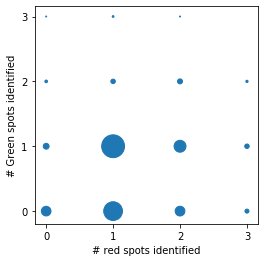

In [196]:
plotOccurence(STEDCRLst)
filterCRLst = selectSpotOccurence(STEDCRLst, [1], [1])

In [220]:
pxSize = 10
Gbg = []
Ybg = []
GA = []
YA = []
Gsigma = []
Ysigma = []
for loc in filterCRLst:
    Gbg.append(loc['G'].spotLst[0].bg)
    Ybg.append(loc['Y'].spotLst[0].bg)
    GA.append(loc['G'].spotLst[0].A * 2 * np.pi * loc['G'].spotLst[0].sigma)
    YA.append(loc['Y'].spotLst[0].A * 2 * np.pi * loc['Y'].spotLst[0].sigma)
    Gsigma.append(loc['G'].spotLst[0].sigma)
    Ysigma.append(loc['Y'].spotLst[0].sigma)

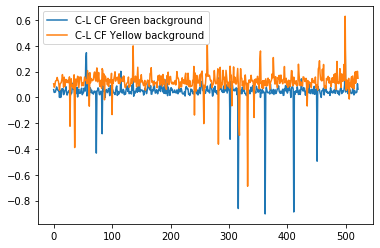

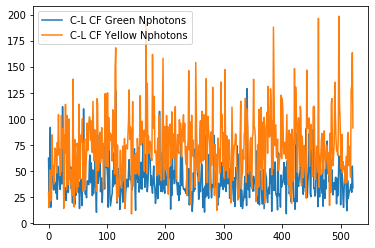

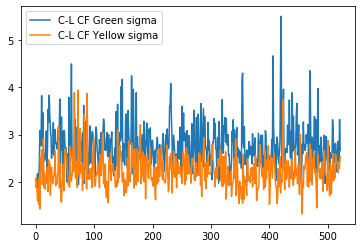

average photons in G: 41 
average photons in Y: 73
average sigma in G: 27.7 
average sigma in Y: 22.2
average bg in G: 0.05 
average bg in Y: 0.12


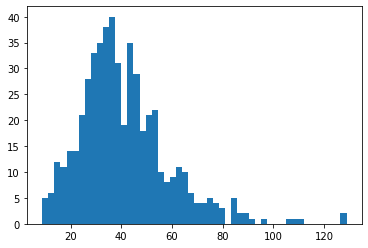

In [221]:
plt.plot(Gbg, label = 'C-L CF Green background')
plt.plot(Ybg, label = 'C-L CF Yellow background')
plt.legend()
plt.show()
plt.plot(GA, label = 'C-L CF Green Nphotons')
plt.plot(YA, label = 'C-L CF Yellow Nphotons')
plt.legend()
plt.show()
plt.plot(Gsigma, label = 'C-L CF Green sigma')
plt.plot(Ysigma, label = 'C-L CF Yellow sigma')
plt.legend()
plt.show()
print('average photons in G: %.0f \naverage photons in Y: %.0f' % (np.mean(GA), np.mean(YA)))
print('average sigma in G: %.1f \naverage sigma in Y: %.1f' % (np.mean(Gsigma) * pxSize, np.mean(Ysigma)*pxSize))
print('average bg in G: %.2f \naverage bg in Y: %.2f' % (np.mean(Gbg), np.mean(Ybg)))

_ = plt.hist(GA, bins = 50)

In [199]:
var = pF.findVar([0,0,27,0.05, 41], 50)
print('standard deviation of G Channel is %.2f' % np.sqrt(var))
var = pF.findVar([0,0,22,0.1, 70], 50)
print('standard deviation of Y Channel is %.2f' % np.sqrt(var))

integral in variance has value -0.004809
standard deviation of G Channel is 4.23
integral in variance has value -0.006799
standard deviation of Y Channel is 2.64


standard deviation of spots is 15.20 and 13.70


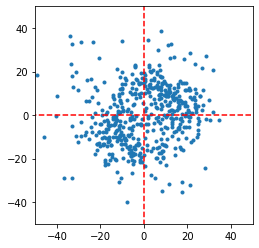

array([ 16.01098551,   6.4855995 , 724.83090176,   2.54738611])

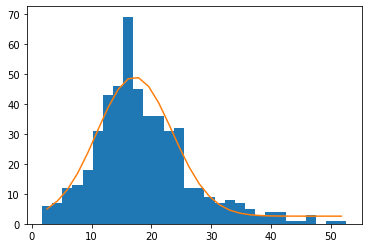

In [202]:
coords = plotSinglePair(filterCRLst, pxSize = pxSize)
counts, bin_edges, _ = plt.hist(np.linalg.norm(coords, axis = 1), bins = 30)
Nbins = bin_edges.shape[0] - 1
bins = np.zeros(Nbins)
for i in range(Nbins):
    bins[i] = (bin_edges[i] + bin_edges[i + 1]) / 2
params0 = [15,3, 500, 10]
fitres = minimize(logLikelihood1D, params0, args = (ncChidistr, bins, counts), 
                  method = 'Nelder-Mead',
                  options = {'maxiter':10000,'maxfev':10000, 'fatol':1e-5})
plt.plot(bins, ncChidistr(bins, *fitres.x))
fitres.x

In [142]:
Nruns = 500
xgrid = np.arange(50) + 0.5
params = [14, 5, 500, 2]
model = ncChidistr(xgrid, *params)
optParams = np.zeros([Nruns, len(params)])
for run in range(Nruns):
    data = np.random.poisson(model)
    params0 = params * (0.8 + 0.4 * np.random.random(len(params)))
    optParams[run] = minimize(logLikelihood1D, params0, args = (ncChidistr, xgrid, data), 
                  method = 'Nelder-Mead',
                  options = {'maxiter':10000,'maxfev':10000, 'fatol':1e-5}).x
    if(run //10 == 0):
        print('finished run %i' run)


In [160]:
print('mu was modelled to be %.2f and found to be %.2f \u00B1 %.2f' % 
      (params[0], np.mean(optParams[:,0]), np.std(optParams[:,0])))
print('sigma was modelled to be %.2f and found to be %.2f \u00B1 %.2f' % 
      (params[1], np.mean(optParams[:,1]), np.std(optParams[:,1])))
print('Amplitude was modelled to be %.0f and found to be %.0f \u00B1 %.0f' % 
      (params[2], np.mean(optParams[:,2]), np.std(optParams[:,2])))
print('offset was modelled to be %.2f and found to be %.2f \u00B1 %.2f' % 
      (params[3], np.mean(optParams[:,3]), np.std(optParams[:,3])))

mu was modelled to be 14.00 and found to be 14.00 ± 0.27
sigma was modelled to be 5.00 and found to be 4.99 ± 0.23
Amplitude was modelled to be 500 and found to be 498 ± 25
offset was modelled to be 2.00 and found to be 2.01 ± 0.29


(array([ 6.,  7., 12., 13., 18., 31., 43., 46., 69., 45., 36., 36., 31.,
        32., 12., 12.,  9.,  7.,  8.,  7.,  5.,  3.,  4.,  4.,  1.,  1.,
         3.,  0.,  1.,  1.]),
 array([ 1.72845227,  3.42493387,  5.12141546,  6.81789706,  8.51437866,
        10.21086026, 11.90734186, 13.60382346, 15.30030505, 16.99678665,
        18.69326825, 20.38974985, 22.08623145, 23.78271304, 25.47919464,
        27.17567624, 28.87215784, 30.56863944, 32.26512104, 33.96160263,
        35.65808423, 37.35456583, 39.05104743, 40.74752903, 42.44401063,
        44.14049222, 45.83697382, 47.53345542, 49.22993702, 50.92641862,
        52.62290021]),
 <a list of 30 Patch objects>)

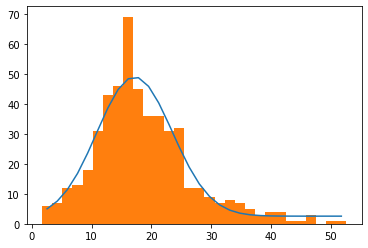